# TP2: Preprocessing and data visualization

## Winter 2023 - BIN710 Data Mining (UdeS)

Second assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── package2.csv    ---> Data

├── product2.csv    ---> Data

├── tp1.ipynb   ---> Jupyter Notebook

└── TP1.pdf    ---> Tasks to complete

### Data
2 files for each dataset and both have the *byte signature*, meaning when compared byte by byte they are similar.

NDC = National Drug Code

### Metadata
Description for the 2 data files used : 
- [Product](https://www.fda.gov/drugs/drug-approvals-and-databases/ndc-product-file-definitions)
- [Package](https://www.fda.gov/drugs/drug-approvals-and-databases/ndc-package-file-definitions)

### Goal
Use preprocessing and data visualization techniques on FDA drugs databases

---

## 1, 2 and 3 : Data verification and cleaning for individual tables (coherence, types, redundency etc.)

Importing all required libraries and modules. Reading file to dataframe with proper encoding

In [1]:
from pathlib import Path
import re

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
root_dir = Path.cwd()
pack = pd.read_csv(root_dir / "package2.csv", delimiter=";")
prod = pd.read_csv(root_dir / "product2.csv", delimiter=";", encoding="ISO-8859-1")    # Latin-1 encoding



### Exploring and cleaning the product data table

In [3]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
0,NaN,0002-0800,HUMAN OTC DRUG,Sterile Diluent,NaN,diluent,"INJECTION, SOLUTION",SUBCUTANEOUS,19870710,NaN,NDA,NDA018781,10,WATER,1,mL/mL,NaN,NaN,N,20201231.0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,Amyvid,NaN,Florbetapir F 18,"INJECTION, SOLUTION",INTRAVENOUS,20120601,NaN,NDA,NDA202008,10,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",NaN,N,20211231.0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20140918,NaN,BLA,BLA125469,10,DULAGLUTIDE,.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20201231.0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20140918,NaN,BLA,BLA125469,10,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20201231.0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,NaN,galcanezumab,"INJECTION, SOLUTION",SUBCUTANEOUS,20180927,NaN,BLA,BLA761063,10,GALCANEZUMAB,120,mg/mL,NaN,NaN,N,20201231.0


In [4]:
print(f"Product dataframe has {prod.shape[0]} objects and {prod.shape[1]} columns.") 

Product dataframe has 93238 objects and 20 columns.


In [5]:
print(f" There are {len(prod.dtypes[prod.dtypes != 'object'])} numerical columns :\n") 
print(prod.dtypes[prod.dtypes != "object"].index.to_list())

 There are 3 numerical columns :

['STARTMARKETINGDATE', 'ENDMARKETINGDATE', 'LISTING_RECORD_CERTIFIED_THROUGH']


In [6]:
print(f" There are {len(prod.dtypes[prod.dtypes == 'object'])} non-numerical columns :\n") 
print(prod.dtypes[prod.dtypes == "object"].index.to_list())

 There are 17 non-numerical columns :

['PRODUCTID', 'PRODUCTNDC', 'PRODUCTTYPENAME', 'PROPRIETARYNAME', 'PROPRIETARYNAMESUFFIX', 'NONPROPRIETARYNAME', 'DOSAGEFORMNAME', 'ROUTENAME', 'MARKETINGCATEGORYNAME', 'APPLICATIONNUMBER', 'LABELERNAME', 'SUBSTANCENAME', 'ACTIVE_NUMERATOR_STRENGTH', 'ACTIVE_INGRED_UNIT', 'PHARM_CLASSES', 'DEASCHEDULE', 'NDC_EXCLUDE_FLAG']


Looking at null/missing values for each feature. We see some feature with very high missing vals such as ProrietaryNameSuffix, EndMarketingDate and DeaSchedule. It makes sense since these are not missing per-se but information on the object itself (No need for suffix on Rx, does have a known end marketing date and no classification of dependency potential respectively)

In [7]:
prod.isnull().sum()

PRODUCTID                            1560
PRODUCTNDC                              0
PRODUCTTYPENAME                         0
PROPRIETARYNAME                         6
PROPRIETARYNAMESUFFIX               83075
NONPROPRIETARYNAME                      4
DOSAGEFORMNAME                          0
ROUTENAME                            1932
STARTMARKETINGDATE                      0
ENDMARKETINGDATE                    88915
MARKETINGCATEGORYNAME                   0
APPLICATIONNUMBER                   13097
LABELERNAME                             0
SUBSTANCENAME                        2309
ACTIVE_NUMERATOR_STRENGTH            2309
ACTIVE_INGRED_UNIT                   2309
PHARM_CLASSES                       50984
DEASCHEDULE                         88815
NDC_EXCLUDE_FLAG                        0
LISTING_RECORD_CERTIFIED_THROUGH     4325
dtype: int64

ProductID is supposed to be composed of ProductNDC and other information. Let's look if if's true

In [8]:
print(f"Num objects with no NA in ProdID/NDC : {len(prod[['PRODUCTID', 'PRODUCTNDC']].dropna())}")

Num objects with no NA in ProdID/NDC : 91678


In [9]:
print(f"Num objects with NDC code within ID col : {prod[['PRODUCTID', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC in x.PRODUCTID, axis=1).sum()}")

Num objects with NDC code within ID col : 91165


In [10]:
prod[prod['PRODUCTID'].notna()].head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
20,0002-3251_67a53369-eead-4f2c-afe9-f3274899c47e,0002-3251,HUMAN PRESCRIPTION DRUG,Strattera,NaN,Atomoxetine hydrochloride,CAPSULE,ORAL,20050214,NaN,NDA,NDA021411,10,ATOMOXETINE HYDROCHLORIDE,100,mg/1,"Norepinephrine Reuptake Inhibitor [EPC],Norepi...",NaN,N,20211231.0
21,0002-3270_06e2a1f2-459c-45aa-9341-54e36f7726a7,0002-3270,HUMAN PRESCRIPTION DRUG,Cymbalta,NaN,Duloxetine hydrochloride,"CAPSULE, DELAYED RELEASE",ORAL,20100115,NaN,NDA,NDA021427,10,DULOXETINE HYDROCHLORIDE,60,mg/1,"Norepinephrine Uptake Inhibitors [MoA],Seroton...",NaN,N,20201231.0
22,0002-4112_d561034d-ea58-45fe-9d07-2e9eba98c2e4,0002-4112,HUMAN PRESCRIPTION DRUG,Zyprexa,NaN,Olanzapine,TABLET,ORAL,19970623,NaN,NDA,NDA020592,10,OLANZAPINE,2.5,mg/1,Atypical Antipsychotic [EPC],NaN,N,20201231.0
23,0002-4115_d561034d-ea58-45fe-9d07-2e9eba98c2e4,0002-4115,HUMAN PRESCRIPTION DRUG,Zyprexa,NaN,Olanzapine,TABLET,ORAL,19961001,NaN,NDA,NDA020592,10,OLANZAPINE,5,mg/1,Atypical Antipsychotic [EPC],NaN,N,20201231.0
24,0002-4116_d561034d-ea58-45fe-9d07-2e9eba98c2e4,0002-4116,HUMAN PRESCRIPTION DRUG,Zyprexa,NaN,Olanzapine,TABLET,ORAL,19961001,NaN,NDA,NDA020592,10,OLANZAPINE,7.5,mg/1,Atypical Antipsychotic [EPC],NaN,N,20201231.0


In [11]:
id_ndc_incoherent = prod[prod['PRODUCTID'].notna()][prod[['PRODUCTID', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC not in x.PRODUCTID, axis=1)]
print(f"Num objects with incoherent ID and NDC : {len(id_ndc_incoherent)}")

Num objects with incoherent ID and NDC : 513


In [12]:
id_ndc_incoherent.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
159,0006-0005_0c7a3452-ecb2-4f66-ad52-94f8eaf8cde8,05-juin,HUMAN PRESCRIPTION DRUG,BELSOMRA,NaN,suvorexant,"TABLET, FILM COATED",ORAL,20140829,NaN,NDA,NDA204569,10,SUVOREXANT,5,mg/1,"Orexin Receptor Antagonist [EPC],Orexin Recept...",CIV,N,20211231.0
160,0006-0019_54e9c31a-9429-4842-b2d6-0cc1e5ad613c,19-juin,HUMAN PRESCRIPTION DRUG,PRINIVIL,NaN,lisinopril,TABLET,ORAL,19871229,NaN,NDA,NDA019558,10,LISINOPRIL,5,mg/1,"Angiotensin Converting Enzyme Inhibitor [EPC],...",NaN,N,20201231.0
310,0009-0003_67759a7c-ea06-4151-87e1-a301c44d67cd,03-sept,HUMAN PRESCRIPTION DRUG,SOLU-MEDROL,NaN,methylprednisolone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19590402,NaN,NDA,NDA011856,Pharmacia and Upjohn Company LLC,METHYLPREDNISOLONE SODIUM SUCCINATE,500,mg/4mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0
311,0009-0005_c9aa26c1-05c3-479c-90eb-63b2181c5e7e,05-sept,HUMAN PRESCRIPTION DRUG,Solu-Cortef,NaN,hydrocortisone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19550427,NaN,NDA,NDA009866,Pharmacia and Upjohn Company LLC,HYDROCORTISONE SODIUM SUCCINATE,1000,mg/8mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0
312,0009-0011_c9aa26c1-05c3-479c-90eb-63b2181c5e7e,11-sept,HUMAN PRESCRIPTION DRUG,Solu-Cortef,NaN,hydrocortisone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19550427,NaN,NDA,NDA009866,Pharmacia and Upjohn Company LLC,HYDROCORTISONE SODIUM SUCCINATE,100,mg/2mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0


In [13]:
# List of possible vals
id_ndc_incoherent["PRODUCTNDC"].unique()

array(['05-juin', '19-juin', '03-sept', '05-sept', '11-sept', '12-sept',
       '13-sept', '16-sept', '17-sept', '18-sept', '20-sept', '22-sept',
       '29-sept', 'OTC MONOGRAPH NOT FINAL', 'NDA', 'OTC MONOGRAPH FINAL',
       'UNAPPROVED HOMEOPATHIC', 'UNAPPROVED MEDICAL GAS',
       'UNAPPROVED DRUG OTHER', 'ANDA', 'NDA AUTHORIZED GENERIC', 'BLA'],
      dtype=object)

We could drop the problematic entries with:

`prod = prod.drop(id_ndc_incoherent.index)` 


In [14]:
prod.iloc[id_ndc_incoherent.index, :].head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
159,0006-0005_0c7a3452-ecb2-4f66-ad52-94f8eaf8cde8,05-juin,HUMAN PRESCRIPTION DRUG,BELSOMRA,NaN,suvorexant,"TABLET, FILM COATED",ORAL,20140829,NaN,NDA,NDA204569,10,SUVOREXANT,5,mg/1,"Orexin Receptor Antagonist [EPC],Orexin Recept...",CIV,N,20211231.0
160,0006-0019_54e9c31a-9429-4842-b2d6-0cc1e5ad613c,19-juin,HUMAN PRESCRIPTION DRUG,PRINIVIL,NaN,lisinopril,TABLET,ORAL,19871229,NaN,NDA,NDA019558,10,LISINOPRIL,5,mg/1,"Angiotensin Converting Enzyme Inhibitor [EPC],...",NaN,N,20201231.0
310,0009-0003_67759a7c-ea06-4151-87e1-a301c44d67cd,03-sept,HUMAN PRESCRIPTION DRUG,SOLU-MEDROL,NaN,methylprednisolone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19590402,NaN,NDA,NDA011856,Pharmacia and Upjohn Company LLC,METHYLPREDNISOLONE SODIUM SUCCINATE,500,mg/4mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0
311,0009-0005_c9aa26c1-05c3-479c-90eb-63b2181c5e7e,05-sept,HUMAN PRESCRIPTION DRUG,Solu-Cortef,NaN,hydrocortisone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19550427,NaN,NDA,NDA009866,Pharmacia and Upjohn Company LLC,HYDROCORTISONE SODIUM SUCCINATE,1000,mg/8mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0
312,0009-0011_c9aa26c1-05c3-479c-90eb-63b2181c5e7e,11-sept,HUMAN PRESCRIPTION DRUG,Solu-Cortef,NaN,hydrocortisone sodium succinate,"INJECTION, POWDER, FOR SOLUTION",INTRAMUSCULAR; INTRAVENOUS,19550427,NaN,NDA,NDA009866,Pharmacia and Upjohn Company LLC,HYDROCORTISONE SODIUM SUCCINATE,100,mg/2mL,"Corticosteroid [EPC],Corticosteroid Hormone Re...",NaN,N,20201231.0


In [15]:
# prod = prod.drop(columns="PRODUCTNDC")

**ProductTypeName FDA labels verification**

In [16]:
content_type_label = pd.read_html("https://www.fda.gov/industry/structured-product-labeling-resources/document-type-including-content-labeling-type")[0]["LOINC Name"]


In [17]:
content_type_label = content_type_label.str.replace("LABEL", "")
content_type_label = content_type_label.str.rstrip().to_list()

In [18]:
print(f'{len([label for label in prod["PRODUCTTYPENAME"].unique() if label not in content_type_label])} producttype categories not in official FDA repo')

0 producttype categories not in official FDA repo


**Dosage form FDA codes verification**

In [19]:
dosage_form_codes = pd.read_html("https://www.fda.gov/industry/structured-product-labeling-resources/dosage-forms")[0]
dosage_form_codes = dosage_form_codes["SPL Acceptable Term"].to_list()


In [20]:
[label for label in prod["DOSAGEFORMNAME"].unique() if label not in dosage_form_codes]
print(f"{len([label for label in prod['DOSAGEFORMNAME'].unique() if label not in dosage_form_codes])} DosageForm categories not in official FDA repo codes")

0 DosageForm categories not in official FDA repo codes


**RouteName FDA codes verification**

In [21]:
routename_codes = pd.read_html("https://www.fda.gov/industry/structured-product-labeling-resources/route-administration")[0]
routename_codes = routename_codes["SPL Acceptable Term"].to_list()


In [22]:
print(f'{len([label for label in prod["ROUTENAME"].dropna().unique() if label not in routename_codes])} RouteNames not listed in official FDA repo')

127 RouteNames not listed in official FDA repo


In [23]:
# Example of multiple categories for RouteName
print([label for label in prod["ROUTENAME"].dropna().unique() if label not in routename_codes][:10])

['INTRAMUSCULAR; SUBCUTANEOUS', 'INTRAVENOUS; SUBCUTANEOUS', 'INTRA-ARTICULAR; INTRAMUSCULAR', 'INTRA-ARTICULAR; INTRALESIONAL', 'INTRAMUSCULAR; INTRAVENOUS', 'INTRALESIONAL; INTRAMUSCULAR; INTRASYNOVIAL; SOFT TISSUE', 'INTRAMUSCULAR; INTRAVENOUS; SUBCONJUNCTIVAL', 'INTRA-ARTICULAR; INTRALESIONAL; INTRAMUSCULAR; SOFT TISSUE', 'INTRAVASCULAR; INTRAVENOUS', 'INTRA-ARTERIAL; INTRAVENOUS']


In [24]:
# Check for lowercase
len(prod["ROUTENAME"].dropna()[prod["ROUTENAME"].str.islower().dropna()])

0

We see it's the objects with multiple categories that have those special labels. This will get fixed with get_dummies method or OneHotEncoding

In [25]:
# Pandas get_dummies example
prod["ROUTENAME"].str.upper().str.get_dummies().head()

,AURICULAR (OTIC),BUCCAL,BUCCAL; DENTAL; TOPICAL,BUCCAL; SUBLINGUAL,BUCCAL; VAGINAL,CUTANEOUS,CUTANEOUS; EXTRACORPOREAL,CUTANEOUS; EXTRACORPOREAL; TOPICAL; VAGINAL,CUTANEOUS; EXTRACORPOREAL; VAGINAL,CUTANEOUS; INTRADERMAL; SUBCUTANEOUS,...,TOPICAL,TOPICAL; TOPICAL,TOPICAL; TOPICAL; TOPICAL,TOPICAL; TRANSDERMAL,TOPICAL; VAGINAL,TRANSDERMAL,TRANSMUCOSAL,URETERAL,URETHRAL,VAGINAL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#ohe example
enc = OneHotEncoder()
enc.fit(pd.DataFrame(prod["ROUTENAME"].str.upper()))
enc.categories_[0][:5]

array(['AURICULAR (OTIC)', 'BUCCAL', 'BUCCAL; DENTAL; TOPICAL',
       'BUCCAL; SUBLINGUAL', 'BUCCAL; VAGINAL'], dtype=object)

Some categories are repeated multiple times with the same routename which does not make sense

In [27]:
prod[prod["ROUTENAME"] == "TOPICAL; TOPICAL; TOPICAL"]

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
74661,68466-0002_b9ea1370-4627-458d-8460-3c1fa0a56f48,68466-0002,HUMAN OTC DRUG,Sports For Trauma Gel,NaN,"Bellis Perennis, Hypericum Perfomatum,Toxicode...",GEL,TOPICAL; TOPICAL; TOPICAL,20040701,NaN,UNAPPROVED HOMEOPATHIC,NaN,"Schwabe Mexico, S.A. de C.V.",BELLIS PERENNIS; HYPERICUM PERFORATUM; TOXICOD...,1; 2; 3; 1,[hp_X]/71g; [hp_X]/71g; [hp_X]/71g; [hp_X]/71g,NaN,NaN,N,20201231.0


In [28]:
# Find the elements with multiple RouteNames
prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].head()

49    INTRAMUSCULAR; SUBCUTANEOUS
52      INTRAVENOUS; SUBCUTANEOUS
55      INTRAVENOUS; SUBCUTANEOUS
70    INTRAMUSCULAR; SUBCUTANEOUS
71    INTRAMUSCULAR; SUBCUTANEOUS
Name: ROUTENAME, dtype: object

In [29]:
# Find all the elements with RouteName repetitions
print(f'Num of RouteName repetitions : {len(prod[prod["ROUTENAME"].str.split("; ").str.len() > 1][prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x : set(x)).str.len() == 1])}')
prod[prod["ROUTENAME"].str.split("; ").str.len() > 1][prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x : set(x)).str.len() == 1].head()

Num of RouteName repetitions : 32


,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
9927,0527-1109_458431c7-41c7-48f4-a8f6-b6b6ccc7cbe2,0527-1109,HUMAN PRESCRIPTION DRUG,Isoniazid,NaN,Isoniazid,TABLET,ORAL; ORAL,20131010,NaN,ANDA,ANDA089776,"Lannett Company, Inc.",ISONIAZID,300,mg/1,Antimycobacterial [EPC],NaN,N,20211231.0
11121,0615-8061_4643015f-3f68-4ecd-909f-85e3fd2c8549,0615-8061,HUMAN PRESCRIPTION DRUG,Lisinopril,NaN,Lisinopril,TABLET,ORAL; ORAL,20111101,20200930.0,ANDA,ANDA076180,"NCS HealthCare of KY, Inc dba Vangard Labs",LISINOPRIL,2.5,mg/1,"Angiotensin Converting Enzyme Inhibitor [EPC],...",NaN,N,NaN
12307,0869-0012_2fd9a395-b322-45b0-b568-71b98e581ae4,0869-0012,HUMAN OTC DRUG,Vitamin A D,NaN,"Lanolin, Petrolatum",OINTMENT,TOPICAL; TOPICAL,20130701,NaN,OTC MONOGRAPH FINAL,part347,Vi-Jon,LANOLIN; PETROLATUM,133; 459,mg/g; mg/g,NaN,NaN,N,20211231.0
17328,16714-114_6ae8605d-16ec-9ea6-8389-ba144c924ee1,16714-114,HUMAN PRESCRIPTION DRUG,Fluoxetine hydrochloride,NaN,Fluoxetine hydrochloride,"TABLET, FILM COATED",ORAL; ORAL,20190918,NaN,ANDA,ANDA211721,NorthStar Rx LLC,FLUOXETINE HYDROCHLORIDE,60,mg/1,"Serotonin Reuptake Inhibitor [EPC],Serotonin U...",NaN,N,20201231.0
29347,43598-632_b7779005-0433-747c-3ea9-16e6d45b6cee,43598-632,HUMAN PRESCRIPTION DRUG,Fluoxetine hydrochloride,NaN,Fluoxetine hydrochloride,"TABLET, FILM COATED",ORAL; ORAL,20190128,NaN,ANDA,ANDA211721,Dr. Reddy's Laboratories Inc.,FLUOXETINE HYDROCHLORIDE,60,mg/1,"Serotonin Reuptake Inhibitor [EPC],Serotonin U...",NaN,N,20201231.0


Shrink to a single categorie for the 32 objects with repetitions

In [30]:
prod.loc[
    prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x: set(x))[prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x: set(x)).str.len() == 1].index,
    "ROUTENAME"
] = prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x: list(set(x))[0])[prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ").apply(lambda x: set(x)).str.len() == 1]
# [prod["ROUTENAME"][prod["ROUTENAME"].str.split("; ").str.len() > 1].str.split("; ")]
# .apply(lambda x : set(x)).str.len() == 1]

**Verifying DateType attributes (START/END/Listing_Record_Certified_Through)**

First let's transform the data from int to datetime format

In [31]:
prod["STARTMARKETINGDATE"] = pd.to_datetime(prod["STARTMARKETINGDATE"], format="%Y%m%d")

In [32]:
print(f'Date range from {min(prod["STARTMARKETINGDATE"])} to {max(prod["STARTMARKETINGDATE"])} for marketing start : OK')

Date range from 1900-01-01 00:00:00 to 2020-02-14 00:00:00 for marketing start : OK


Error for 3031 year in timestamp of EndMarketingDate. Let's fix it to 2031

In [33]:
# pd.to_datetime(prod["ENDMARKETINGDATE"], format="%Y%m%d")
prod["ENDMARKETINGDATE"].sort_values(ascending=False).head()

29503    30310209.0
65640    20390831.0
46709    20380131.0
89575    20331010.0
89576    20331010.0
Name: ENDMARKETINGDATE, dtype: float64

In [34]:
prod.loc[prod["ENDMARKETINGDATE"] > 20500000, ["ENDMARKETINGDATE"]] = 30310209.0 - 10000000

In [35]:
print(prod.iloc[29503]["ENDMARKETINGDATE"])    # Check replacement

20310209.0


In [36]:
# Converting the actual data
prod["ENDMARKETINGDATE"] = pd.to_datetime(prod["ENDMARKETINGDATE"], format="%Y%m%d")

In [37]:
print(f'Date range from {min(prod["ENDMARKETINGDATE"].dropna())} to {max(prod["ENDMARKETINGDATE"].dropna())} for marketing end : OK')

Date range from 2020-02-15 00:00:00 to 2039-08-31 00:00:00 for marketing end : OK


No objects with incongruent start/end date combinations

In [38]:
print(f'Number of objects with enddates greather than start dates : {len(prod[prod["ENDMARKETINGDATE"] < prod["STARTMARKETINGDATE"]])}')

Number of objects with enddates greather than start dates : 0


Listing records to date time, no incongruencies

In [39]:
prod["LISTING_RECORD_CERTIFIED_THROUGH"] = pd.to_datetime(prod["LISTING_RECORD_CERTIFIED_THROUGH"], format="%Y%m%d")

In [40]:
print(f'Date range from {min(prod["LISTING_RECORD_CERTIFIED_THROUGH"].dropna())} to {max(prod["LISTING_RECORD_CERTIFIED_THROUGH"].dropna())} for marketing end : OK')

Date range from 2020-12-31 00:00:00 to 2021-12-31 00:00:00 for marketing end : OK


In [41]:
print(f'Number of objects with listing certified greather than start dates : {len(prod[prod["LISTING_RECORD_CERTIFIED_THROUGH"] < prod["STARTMARKETINGDATE"]])}')

Number of objects with listing certified greather than start dates : 0


**Let's transform the date columns with massive amount of NaN because the dates are not missing but not determined**

In [42]:
na75_threshold = 0.75*len(prod)
print(na75_threshold)

69928.5


In [43]:
print(prod.isnull().sum()[prod.isnull().sum() > na75_threshold].index.to_list())

['PROPRIETARYNAMESUFFIX', 'ENDMARKETINGDATE', 'DEASCHEDULE']


**DEASchedule verification codes**

In [44]:
deas_codes = ["CI", "CII", "CIII", "CIV", "CV"]
print(len([label for label in prod["DEASCHEDULE"].dropna().unique() if label not in deas_codes]))

0


Let's replace it with a binary feature anyway since most of them are not determined

Replacing ENDMARKETINGDATE with determined/notdetermined binary

In [45]:
# Testing the logic
pd.DataFrame(np.where(prod["ENDMARKETINGDATE"].notnull(), 1, 0)).value_counts()

0    88915
1     4323
dtype: int64

In [46]:
pd.DataFrame(np.where(prod["DEASCHEDULE"].notnull(), 1, 0)).value_counts()

0    88815
1     4423
dtype: int64

In [47]:
# Replacing values
prod["ENDMARKETINGDATE_determined"] = np.where(prod["ENDMARKETINGDATE"].notnull(), 1, 0)
prod["DEASCHEDULE_determined"] = np.where(prod["DEASCHEDULE"].notnull(), 1, 0)

In [48]:
prod = prod.drop(columns=["ENDMARKETINGDATE", "DEASCHEDULE"])

**Application Number verification to startwith FDA reference codes**

In [49]:
# Does not matc prefix NDA / ANDA / BLA or partXXXX in ApplicationNumber
prod["APPLICATIONNUMBER"].dropna()[prod["APPLICATIONNUMBER"].dropna().str.match("^[^NDA|^ANDA|^BLA|^part]")]

26428    333D
Name: APPLICATIONNUMBER, dtype: object

Let's remove that object

In [50]:
prod = prod.drop(prod["APPLICATIONNUMBER"].dropna()[prod["APPLICATIONNUMBER"].dropna().str.match("^[^NDA|^ANDA|^BLA|^part]")].index)

In [51]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH,ENDMARKETINGDATE_determined,DEASCHEDULE_determined
0,NaN,0002-0800,HUMAN OTC DRUG,Sterile Diluent,NaN,diluent,"INJECTION, SOLUTION",SUBCUTANEOUS,1987-07-10,NDA,NDA018781,10,WATER,1,mL/mL,NaN,N,2020-12-31,0,0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,Amyvid,NaN,Florbetapir F 18,"INJECTION, SOLUTION",INTRAVENOUS,2012-06-01,NDA,NDA202008,10,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",N,2021-12-31,0,0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,2014-09-18,BLA,BLA125469,10,DULAGLUTIDE,.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,2014-09-18,BLA,BLA125469,10,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,NaN,galcanezumab,"INJECTION, SOLUTION",SUBCUTANEOUS,2018-09-27,BLA,BLA761063,10,GALCANEZUMAB,120,mg/mL,NaN,N,2020-12-31,0,0


**Verify if ApplicationNumber prefix and MarketingCategoryName are identical**

In [52]:
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].isnull().sum()

MARKETINGCATEGORYNAME        0
APPLICATIONNUMBER        13097
dtype: int64

Let's look at the values for MarketingCategoryName when ApplicationNumber is null because they are linked

In [53]:
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]][prod["APPLICATIONNUMBER"].isnull()].head()

,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
738,UNAPPROVED DRUG OTHER,NaN
750,UNAPPROVED DRUG OTHER,NaN
2262,UNAPPROVED DRUG OTHER,NaN
2307,UNAPPROVED DRUG OTHER,NaN
2822,UNAPPROVED DRUG OTHER,NaN


In [54]:
prod["MARKETINGCATEGORYNAME"][prod["APPLICATIONNUMBER"].isnull()].unique()

array(['UNAPPROVED DRUG OTHER', 'UNAPPROVED HOMEOPATHIC',
       'UNAPPROVED MEDICAL GAS',
       'UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE'], dtype=object)

List of the categories where ApplicationNumber prefix does not match MarketingCategoryName show that NDA and AND have some mismatch between the 2 features

In [55]:
print(prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"], axis=1)]["MARKETINGCATEGORYNAME"].unique())

['OTC MONOGRAPH NOT FINAL' 'OTC MONOGRAPH FINAL' 'NDA AUTHORIZED GENERIC'
 'NDA' 'ANDA']


OK for OTC MONOGRAPH + NDA AUTHORIZED GENERIC entries according to FDA website

In [56]:
# Entries with NDA AUTHORIZED GENERIC AND NOT STARTING WITH NDAXXXXX IN APPLICATION NUMBER
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "NDA AUTHORIZED GENERIC", axis=1)]["APPLICATIONNUMBER"].str.contains("^[^NDA]").sum()

0

In [57]:
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "OTC MONOGRAPH FINAL", axis=1)].head()


,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
484,OTC MONOGRAPH FINAL,part349
485,OTC MONOGRAPH FINAL,part349
488,OTC MONOGRAPH FINAL,part349
489,OTC MONOGRAPH FINAL,part349
490,OTC MONOGRAPH FINAL,part349


In [58]:
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "OTC MONOGRAPH FINAL", axis=1)].head()


,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
484,OTC MONOGRAPH FINAL,part349
485,OTC MONOGRAPH FINAL,part349
488,OTC MONOGRAPH FINAL,part349
489,OTC MONOGRAPH FINAL,part349
490,OTC MONOGRAPH FINAL,part349


In [59]:
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "NDA AUTHORIZED GENERIC", axis=1)].head()


,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
996,NDA AUTHORIZED GENERIC,NDA020850
997,NDA AUTHORIZED GENERIC,NDA020850
998,NDA AUTHORIZED GENERIC,NDA020850
999,NDA AUTHORIZED GENERIC,NDA021162
1000,NDA AUTHORIZED GENERIC,NDA021162


Incongruencies for ANDA and NDA labelled objects in ApplicationNumber

In [60]:
# For ANDA in Marketing
print(f'{len(prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "ANDA", axis=1)])} mislabelled ANDA samples')
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "ANDA", axis=1)].head()


12 mislabelled ANDA samples


,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
9209,ANDA,BA740193
9228,ANDA,BA720563
9229,ANDA,BA720562
16915,ANDA,BA010228
16916,ANDA,BA010228


In [61]:
# NDA mislabelled
print(f'{len(prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "NDA", axis=1)])} mislabelled NDA samples')
prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "NDA", axis=1)].head()

126 mislabelled NDA samples


,MARKETINGCATEGORYNAME,APPLICATIONNUMBER
5955,NDA,BN890105
8905,NDA,BN070012
8966,NDA,BN200952
13099,NDA,BN160918
13100,NDA,BN160918


No way to determine which is correct so drop those entries

In [62]:
prod = prod.drop(prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "ANDA", axis=1)].index)
prod = prod.drop(prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna()[prod[["MARKETINGCATEGORYNAME","APPLICATIONNUMBER"]].dropna().apply(lambda x : x["MARKETINGCATEGORYNAME"] not in x["APPLICATIONNUMBER"] and x["MARKETINGCATEGORYNAME"] == "NDA", axis=1)].index)


ProprietaryName seems all over the place and there are no standard format/regulations for this feature. Maybe delete it later on since it might not bring valuable information. At least convert to upper/lowercase before OneHotEncoding

In [63]:
# Example propname
print(prod["PROPRIETARYNAME"].sort_values().unique()[:50])

['(CHLOROPROCAINE HCI' '.Insulin Aspart Protamine and Insulin Aspart'
 '0.9% SODIUM CHLORIDE' '02 CUSHION SPF45' '1 Bladder' '1 Detoxification'
 '1% Hydrocortisone' '1% LIDOCAINE HCI'
 '1.8OZ HAND SANITIZER WITH CLIP -ASSORTED'
 '1.8oz Armstrong Hand Sanitizer with Aloe Vera and Vitamin E'
 '10 Armani Prima Control Glow Moisturizer SBS SPF 35' '10 PARASITE DETOX'
 '10 Parasite Detox' '10 TREE MIX' '100% Pure Yerba Mate MIst'
 '1000 Roses CC Color Plus Correct Sheer Tan SPF 30'
 '1000 Roses CC Color plus Correct Sheer Nude SPF 30'
 '1000 Roses Daily Shade Facial SPF 18' '1012 Antimicrobial'
 '10g Colgate plus Toothbrush Kit'
 '10g Colgate plus Toothbrush plus Floss Kit' '11 Tree Pollen Mix'
 '111 Medco Benzoyl Peroxide' '12 Hour Nasal' '12 Hour Nasal Decongestant'
 '12 Hour Original Nasal Decongestant' '12 hour allergy and congestion'
 '12 hour allergy d' '12 hour decongestant'
 '12HR Allergy and Congestion Relief' '16OZ HYDORGEN PEROXIDE'
 '1ST MEDXPATCH' '1st RELIEF TOPICAL' '2 Cockro

In [64]:
prod["PROPRIETARYNAME"] = prod["PROPRIETARYNAME"].str.upper()

There are a lot of similar companies with just slight variations in their name. It might lead to more confusion or decreasing the model metrics such as Accuracy and F1 scores.

For example look at the 5 different name variations for 7-eleven

In [65]:
prod["LABELERNAME"].sort_values().unique()[:50]

array(['- INDUSTRIAL WELDING SUPPLY CO. OF HARVEY, INC.',
       "-L'Oreal USA Products Inc", '.Cardinal Health',
       '1 Veterans Health', '10', '101196749', '111 Medco',
       '1ST MEDX LLC', '1st Class Pharmaceuticals, Inc.', '2 Transform',
       '20Lighter, LLC.', '21st Century Designer Health Products',
       '21st Century Formulations', '21st Century Homeopathics',
       '21st Century Homeopathics, Inc', '2xl Corporation', '3014704014',
       '3D Imaging Drug Design and Development LLC', '3LAB', '3LAB, Inc',
       '3LAB, Inc.', '3M Company', '3M ESPE Dental Products',
       '3M Health Care', '4E Global, S.A.P.I. de C.V',
       '4Life Research USA, LLC', '4e Brands Northamerica LLC',
       '4sport D.o.o.', '5 SENCO Inc.', '60 Degrees Pharmaceuticals, LLC',
       '65364-110', '7-ELEVEN', '7-ELEVEN, INC.', '7-Eleven',
       '7-Eleven Inc', '7-Eleven Inc.', '7-Eleven, Inc.', '7-Select, Inc',
       '7-eleven', '714 Essentials LTD', '7T Pharma LLC',
       '8.0 IDEAL BALA

In [66]:
len(prod["LABELERNAME"].unique())

6599

Replace to uppercase to control for case-sensitive str

In [67]:
prod["LABELERNAME"] = prod["LABELERNAME"].str.upper()

We might need to drop the ProprietaryName since it there is no standard and so many different unique categories it won't bring anything good to the model

In [68]:
len(prod["PROPRIETARYNAME"].unique())

29723

Suffix feature will mostly not contribute a lot of relevant information since there are not really a standard and many incongruency in naming

In [69]:
print(f"{len(prod['PROPRIETARYNAMESUFFIX'].dropna())} values for PPTsuffix with {len(prod['PROPRIETARYNAMESUFFIX'].dropna().unique())} unique categories")

10157 values for PPTsuffix with 4019 unique categories


In [70]:
# See a few examples
print(prod['PROPRIETARYNAMESUFFIX'].dropna().unique()[:10])

['Zydis ' 'Mix75/25 ' 'Mix50/50 ' 'Intramuscular ' 'Relprevv ' 'KwikPen '
 ' Junior KwikPen ' ' Tempo Pen ' 'R ' 'N ']


Transform to a `PROPRIETARYNAMESUFFIX_determined` attribute to account for that high proportion of missing data

In [71]:
pd.DataFrame(np.where(prod["PROPRIETARYNAMESUFFIX"].notnull(), 1, 0)).value_counts()

0    82942
1    10157
dtype: int64

In [72]:
# Replacing vals
prod["PROPRIETARYNAMESUFFIX_determined"] = np.where(prod["PROPRIETARYNAMESUFFIX"].notnull(), 1, 0)

In [73]:
# Droping original feature
prod = prod.drop(columns="PROPRIETARYNAMESUFFIX")

**No other cleanup/checkup except to convert to uppercase/lowercase before OneHotEncoding of NonProprietaryName to avoid repeated categories. NonProprietaryName is the list of activate ingredients and has a standard naming convention so it will be usefull for the classification task**

In [74]:
prod["NONPROPRIETARYNAME"] = prod["NONPROPRIETARYNAME"].str.upper()

In [75]:
prod["NONPROPRIETARYNAME"].head()

0             DILUENT
1    FLORBETAPIR F 18
2         DULAGLUTIDE
3         DULAGLUTIDE
4        GALCANEZUMAB
Name: NONPROPRIETARYNAME, dtype: object

**SubstanceName, ACTIVATE_NUMERATOR_STRENGTH (which on the FDA website is labelled as StrengthNumber) and ACTIVE_INGRED_UNIT are linked features. They also can have multiple values each when split by a semi colon. Let's look if the number of multiple values match its counterpart in each feature**

Looking at the frequency of number of elements per value. They look similar.

In [76]:
prod["SUBSTANCENAME"].str.split(";").str.len().astype(str).value_counts()[:6]

1.0    69757
2.0     9480
3.0     4497
4.0     2677
nan     2252
5.0     1124
Name: SUBSTANCENAME, dtype: int64

In [77]:
prod["ACTIVE_NUMERATOR_STRENGTH"].str.split(";").str.len().astype(str).value_counts()[:6]

1.0    69757
2.0     9481
3.0     4496
4.0     2677
nan     2252
5.0     1124
Name: ACTIVE_NUMERATOR_STRENGTH, dtype: int64

In [78]:
prod["ACTIVE_INGRED_UNIT"].str.split(";").str.len().astype(str).value_counts()[:6]

1.0    69757
2.0     9481
3.0     4496
4.0     2677
nan     2252
5.0     1124
Name: ACTIVE_INGRED_UNIT, dtype: int64

Looking at differences in amount of categories per objects for SubstanceName and ACTIVE_NUMERATOR_STRENGTH

In [79]:
prod[prod["SUBSTANCENAME"].str.split(";").str.len() != prod["ACTIVE_NUMERATOR_STRENGTH"].str.split(";").str.len()][["SUBSTANCENAME", "ACTIVE_NUMERATOR_STRENGTH"]].head()

,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH
49,NaN,NaN
58,NaN,NaN
59,NaN,NaN
60,NaN,NaN
69,NaN,NaN


Mostly NaN except...

In [80]:
prod[prod["SUBSTANCENAME"].str.split(";").str.len() != prod["ACTIVE_NUMERATOR_STRENGTH"].str.split(";").str.len()][["SUBSTANCENAME", "ACTIVE_NUMERATOR_STRENGTH"]].dropna()

,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH
90536,GLYCERIN; HYDROLYZED SOY PROTEIN (ENZYMATIC; 2...,10; .12


In [81]:
prod[prod["ACTIVE_NUMERATOR_STRENGTH"].str.split(";").str.len() != prod["ACTIVE_INGRED_UNIT"].str.split(";").str.len()][["ACTIVE_NUMERATOR_STRENGTH", "ACTIVE_INGRED_UNIT"]].dropna()

,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT


In [82]:
# drop the problematic object
prod = prod.drop(
    prod[prod["SUBSTANCENAME"].str.split(";").str.len() != prod["ACTIVE_NUMERATOR_STRENGTH"].str.split(";").str.len()][["SUBSTANCENAME", "ACTIVE_NUMERATOR_STRENGTH"]].dropna().index
)

While it does not mean that the number of classes matches the number of substances !

In [83]:
len(prod[prod["SUBSTANCENAME"].str.split(";").str.len() != prod["PHARM_CLASSES"].str.split(",").str.len()][ "PHARM_CLASSES"])

89302

Looking now at a possible OneHotEncoding approach to deal with multiple values per instance

In [84]:
print("ohe len categories for SubstanceName")
print(len(OneHotEncoder().fit(pd.DataFrame(prod["SUBSTANCENAME"].str.upper())).categories_[0]))
print("ohe len categories for ACTIVE_NUMERATOR_STRENGTH")
print(len(OneHotEncoder().fit(pd.DataFrame(prod["ACTIVE_NUMERATOR_STRENGTH"].str.upper())).categories_[0]))
print("ohe len categories for ACTIVE_INGRED_UNIT")
print(len(OneHotEncoder().fit(pd.DataFrame(prod["ACTIVE_INGRED_UNIT"].str.upper())).categories_[0]))

ohe len categories for SubstanceName
8949
ohe len categories for ACTIVE_NUMERATOR_STRENGTH
8737
ohe len categories for ACTIVE_INGRED_UNIT
2377


That amount of categories with OneHotEncoding might lead to overfitting, let's look at another avenue to deal with multiple values per instance those features

In [85]:
linked_multiple_vals_feats = ["SUBSTANCENAME", "ACTIVE_NUMERATOR_STRENGTH", "ACTIVE_INGRED_UNIT"]

In [86]:
# Example with at least 2 multiple values in those features
prod[prod[linked_multiple_vals_feats].apply(lambda x: x.str.split(";").str[1]).notnull().any(axis=1)][linked_multiple_vals_feats]

,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT
11,OLANZAPINE; FLUOXETINE HYDROCHLORIDE,3; 25,mg/1; mg/1
12,OLANZAPINE; FLUOXETINE HYDROCHLORIDE,6; 25,mg/1; mg/1
13,OLANZAPINE; FLUOXETINE HYDROCHLORIDE,6; 50,mg/1; mg/1
14,OLANZAPINE; FLUOXETINE HYDROCHLORIDE,12; 50,mg/1; mg/1
121,ATAZANAVIR SULFATE; COBICISTAT,300; 150,mg/1; mg/1
...,...,...,...
93131,AVOBENZONE; OCTINOXATE; OCTISALATE; OCTOCRYLENE,.9; 1.3; 1.3; .6,g/30mL; g/30mL; g/30mL; g/30mL
93161,AVOBENZONE; HOMOSALATE; OCTISALATE; OCTOCRYLENE,.0306; .0816; .051; .0816,g/mL; g/mL; g/mL; g/mL
93162,MENTHOL; EUCALYPTUS OIL; CAMPHOR (SYNTHETIC),1; 1; 4.7,g/100g; g/100g; g/100g
93229,HYDROQUINONE; OXYBENZONE; PADIMATE O,20; 25; 33,mg/g; mg/g; mg/g


We could get all the element positions for the first 5 elements for each of the feature, meaning we would split in 15 new features

In [87]:
# Custom dummies-like method for first5
for i in range(5):
    # print([f"{feat}_{i}" for feat in multiple_vals_feats])
    prod[[f"{feat}_{i}" for feat in linked_multiple_vals_feats]] = prod[linked_multiple_vals_feats].apply(lambda x: x.str.split(";").str[i])

In [88]:
prod.isnull().sum()[20:]

SUBSTANCENAME_0                 2252
ACTIVE_NUMERATOR_STRENGTH_0     2252
ACTIVE_INGRED_UNIT_0            2252
SUBSTANCENAME_1                72009
ACTIVE_NUMERATOR_STRENGTH_1    72009
ACTIVE_INGRED_UNIT_1           72009
SUBSTANCENAME_2                81489
ACTIVE_NUMERATOR_STRENGTH_2    81489
ACTIVE_INGRED_UNIT_2           81489
SUBSTANCENAME_3                85985
ACTIVE_NUMERATOR_STRENGTH_3    85985
ACTIVE_INGRED_UNIT_3           85985
SUBSTANCENAME_4                88662
ACTIVE_NUMERATOR_STRENGTH_4    88662
ACTIVE_INGRED_UNIT_4           88662
dtype: int64

This is a lot of NaN but we will loose the link to pharm_classes if we only keep those. We have to choose a different approach like OneHotEncoding where the newfeature generated do not have NaN

In [89]:
for i in range(5):
    for feat in linked_multiple_vals_feats:
        prod = prod.drop(columns=f"{feat}_{i}")

In [90]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH,ENDMARKETINGDATE_determined,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,"INJECTION, SOLUTION",SUBCUTANEOUS,1987-07-10,NDA,NDA018781,10,WATER,1,mL/mL,NaN,N,2020-12-31,0,0,0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,"INJECTION, SOLUTION",INTRAVENOUS,2012-06-01,NDA,NDA202008,10,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",N,2021-12-31,0,0,0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,"INJECTION, SOLUTION",SUBCUTANEOUS,2014-09-18,BLA,BLA125469,10,DULAGLUTIDE,.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0,0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,"INJECTION, SOLUTION",SUBCUTANEOUS,2014-09-18,BLA,BLA125469,10,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0,0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,"INJECTION, SOLUTION",SUBCUTANEOUS,2018-09-27,BLA,BLA761063,10,GALCANEZUMAB,120,mg/mL,NaN,N,2020-12-31,0,0,0


**In the end we will convert the multiple values features in a list (see a few cells below) and probably will go for MultiLabelEncoding when creating our classification model**

#### Converting features with multiple values per objects : ROUTENAME and 3 linked attributes of SubstanceName, Activte_NUMERATOR_STRENGHT, Activte_UNIT

In [91]:
# semicolon separated entries
for col in prod.columns:
    if not col == "LABELERNAME":
        if prod[col].astype(str).str.contains("; ").sum() > 0:
            print(f'{col} feature contains {prod[col].astype(str).str.contains(";").sum()} entries with multiple elements')

ROUTENAME feature contains 4318 entries with multiple elements
SUBSTANCENAME feature contains 21089 entries with multiple elements
ACTIVE_NUMERATOR_STRENGTH feature contains 21089 entries with multiple elements
ACTIVE_INGRED_UNIT feature contains 21089 entries with multiple elements


In [92]:
# comma separated entries
for col in prod.columns:
    if prod[col].astype(str).str.contains(",").sum() > 0:
        print(f'{col} feature contains {prod[col].astype(str).str.contains(",").sum()} entries with multiple elements')

PROPRIETARYNAME feature contains 1036 entries with multiple elements
NONPROPRIETARYNAME feature contains 14814 entries with multiple elements
DOSAGEFORMNAME feature contains 27739 entries with multiple elements
APPLICATIONNUMBER feature contains 4 entries with multiple elements
LABELERNAME feature contains 34549 entries with multiple elements
SUBSTANCENAME feature contains 2073 entries with multiple elements
PHARM_CLASSES feature contains 39104 entries with multiple elements


Some of them are not truly multiple elements (see below)

In [93]:
prod["ROUTENAME"].str.split(";").str.len().value_counts()

1.0    86894
2.0     2224
3.0     1846
4.0      188
5.0       48
6.0        9
9.0        2
7.0        1
Name: ROUTENAME, dtype: int64

We can filter for routename with 3 elements only and put the rest in another category

In [94]:
prod["ROUTENAME_list"] = prod["ROUTENAME"].str.split("; ")

In [95]:
prod[prod["ROUTENAME_list"].isnull()].head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,...,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH,ENDMARKETINGDATE_determined,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list
69,0002-8031_f43b949f-3a0a-43bf-863d-4de52abe5faf,0002-8031,HUMAN PRESCRIPTION DRUG,GLUCAGON,GLUCAGON,KIT,NaN,1999-03-01,NDA,NDA020928,...,NaN,NaN,NaN,NaN,N,2020-12-31,0,0,0,NaN
123,0003-3764_507c9bab-1385-4e6b-95c1-fa8578a8a901,0003-3764,HUMAN PRESCRIPTION DRUG,ELIQUIS,APIXABAN,KIT,NaN,2017-11-29,NDA,NDA202155,...,NaN,NaN,NaN,NaN,N,2020-12-31,0,0,1,NaN
149,0004-0381_0b811e50-d0e0-4679-8d14-d9c91e867334,0004-0381,HUMAN PRESCRIPTION DRUG,FUZEON,ENFUVIRTIDE,KIT,NaN,2012-04-10,NDA,NDA021481,...,NaN,NaN,NaN,NaN,N,2020-12-31,0,0,0,NaN
222,0006-3862_137e0347-9e23-4cc0-a44a-8c88d8983e17,0006-3862,HUMAN PRESCRIPTION DRUG,EMEND,APREPITANT,KIT,NaN,2003-03-26,NDA,NDA021549,...,NaN,NaN,NaN,NaN,N,2021-12-31,0,0,0,NaN
264,0006-5424_7ef0f037-02b3-417c-a736-23b9e9c6dd5a,0006-5424,PLASMA DERIVATIVE,ANTIVENIN,LATRODECTUS MACTANS,KIT,NaN,2014-12-01,BLA,BLA101062,...,NaN,NaN,NaN,NaN,N,2020-12-31,0,0,0,NaN


In [96]:
# Replace NaN with [UNKNOWN]
# prod["ROUTENAME_list"] = prod["ROUTENAME_list"].fillna("").apply(lambda x: ["UNKNOWN"] if x == "" else x)

In [97]:
prod["ROUTENAME_list"].value_counts().head()

[ORAL]                                       54716
[TOPICAL]                                    21557
[INTRAVENOUS]                                 3291
[INTRADERMAL, PERCUTANEOUS, SUBCUTANEOUS]     1315
[RESPIRATORY (INHALATION)]                    1257
Name: ROUTENAME_list, dtype: int64

In [98]:
# Drop routename
prod = prod.drop(columns="ROUTENAME")

Transforming multiple labels to list for 3 linked attributes : substancename, Activte_NUMERATOR_STRENGHT, Activte_UNIT

In [99]:
prod["SUBSTANCENAME_list"] = prod["SUBSTANCENAME"].str.split("; ")
prod["ACTIVE_NUMERATOR_STRENGTH_list"] = prod["ACTIVE_NUMERATOR_STRENGTH"].str.split("; ")
prod["ACTIVE_INGRED_UNIT_list"] = prod["ACTIVE_INGRED_UNIT"].str.split("; ")

In [100]:
# Dropping the ori feature
prod = prod.drop(columns=["SUBSTANCENAME", "ACTIVE_NUMERATOR_STRENGTH", "ACTIVE_INGRED_UNIT"])

**Comma separated values**

This one is a bit tricky. I'll just leave it as is and labelencode it later since some are comma separated and some are not

In [101]:
prod[prod["NONPROPRIETARYNAME"].str.split(",").str.len() > 2]["NONPROPRIETARYNAME"]

221      IMIPENEM ANHYDROUS, CILASTATIN, AND RELEBACTAM...
228      HUMAN PAPILLOMAVIRUS QUADRIVALENT (TYPES 6, 11...
229             ROTAVIRUS VACCINE, LIVE, ORAL, PENTAVALENT
234      HUMAN PAPILLOMAVIRUS QUADRIVALENT (TYPES 6, 11...
237      MEASLES, MUMPS, RUBELLA AND VARICELLA VIRUS VA...
                               ...                        
93130    AVOBENZONE, OCTINOXATE, OCTISALATE, AND OCTOCR...
93131    AVOBENZONE, OCTINOXATE, OCTISALATE, AND OCTOCR...
93161    AVOBENZONE, HOMOSALATE, OCTISALATE, AND OCTOCR...
93162                     MENTHOL, CAMPHOR, EUCALYPTUS OIL
93229             HYDROQUINONE, OXYBENZONE, AND PADIMATE O
Name: NONPROPRIETARYNAME, Length: 10370, dtype: object

We can remove the 4 ApplicationNumber outliers

In [102]:
prod["APPLICATIONNUMBER"].dropna()[prod["APPLICATIONNUMBER"].dropna().str.contains(",")]

64347    part356,part355
64348    part356,part355
76899    part341,part348
85113    part341,part348
Name: APPLICATIONNUMBER, dtype: object

In [103]:
prod = prod.drop(prod["APPLICATIONNUMBER"].dropna()[prod["APPLICATIONNUMBER"].dropna().str.contains(",")].index)

Let's convert DosageFormName

In [104]:
prod["DOSAGEFORMNAME"].str.split(", ").str.len().value_counts()

1    65355
2    25001
3     1955
4      783
Name: DOSAGEFORMNAME, dtype: int64

In [105]:
# Convert and drop ori feature
prod["DOSAGEFORMNAME_list"] = prod["DOSAGEFORMNAME"].str.split(", ")


In [106]:
prod = prod.drop(columns="DOSAGEFORMNAME")

In [107]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH,ENDMARKETINGDATE_determined,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,N,2020-12-31,0,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]"
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",N,2021-12-31,0,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]"
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]"
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",N,2020-12-31,0,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]"
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,N,2020-12-31,0,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]"


**NDC_Exclude_Flag codes verification**

In [108]:
ndc_exclude_codes = ["E", "U", "I"]
print([label for label in prod["NDC_EXCLUDE_FLAG"].unique()])

['N']


In [109]:
prod["NDC_EXCLUDE_FLAG"].value_counts()

N    93094
Name: NDC_EXCLUDE_FLAG, dtype: int64

Easy dropping that column since they are all the same value

In [110]:
prod = prod.drop(columns="NDC_EXCLUDE_FLAG")

**LISTING_RECORD_CERTIFIED_THROUGH dates verification**

In [111]:
print(f"Max time : {max(prod['LISTING_RECORD_CERTIFIED_THROUGH'])}")
print(f"Min time : {min(prod['LISTING_RECORD_CERTIFIED_THROUGH'])}")

Max time : 2021-12-31 00:00:00
Min time : 2020-12-31 00:00:00


<Axes: xlabel='LISTING_RECORD_CERTIFIED_THROUGH', ylabel='Count'>

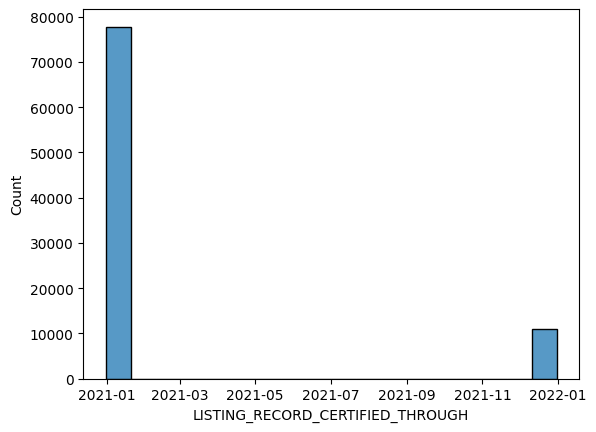

In [112]:
sns.histplot(prod, x="LISTING_RECORD_CERTIFIED_THROUGH")

In [113]:
print(f"There are {len(prod['LISTING_RECORD_CERTIFIED_THROUGH'].unique())} unique values for LISTING_RECORD_CERTIFIED_THROUGH")

There are 3 unique values for LISTING_RECORD_CERTIFIED_THROUGH


In [114]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,LISTING_RECORD_CERTIFIED_THROUGH,ENDMARKETINGDATE_determined,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,2020-12-31,0,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]"
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",2021-12-31,0,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]"
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",2020-12-31,0,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]"
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",2020-12-31,0,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]"
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,2020-12-31,0,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]"


In [115]:
# Replace pd.NaT with undetermined str and converting get dummies
prod["LISTING_RECORD_CERTIFIED_THROUGH"] = prod["LISTING_RECORD_CERTIFIED_THROUGH"].fillna("undetermined")
prod = pd.get_dummies(prod, columns=["LISTING_RECORD_CERTIFIED_THROUGH"])

In [116]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,...,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]",1,0,0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",...,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]",0,1,0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,...,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]",1,0,0


Not sure how much it will bring to the model. In any case, we can convert it to numerical since there are 3 categories total

**PHARM_CLASSES Verification and correction**

In [117]:
print(f"There are {prod['PHARM_CLASSES'].isnull().sum()} missing values for PHARM_CLASSES")

There are 50917 missing values for PHARM_CLASSES


In [118]:
# Counts of Number of classes per objects
prod["PHARM_CLASSES"].str.split(",").str.len().sort_values().astype(str).value_counts()[:6]

nan    50917
2.0    23254
3.0     5039
4.0     3424
1.0     3073
5.0     3005
Name: PHARM_CLASSES, dtype: int64

In [119]:
prod["PHARM_CLASSES"].head()

0                                                  NaN
1    Radioactive Diagnostic Agent [EPC],Positron Em...
2    GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...
3    GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...
4                                                  NaN
Name: PHARM_CLASSES, dtype: object

**Extracting only the PHARM_CLASS code**

In [120]:
prod["PHARM_CLASSES"].head()

0                                                  NaN
1    Radioactive Diagnostic Agent [EPC],Positron Em...
2    GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...
3    GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...
4                                                  NaN
Name: PHARM_CLASSES, dtype: object

In [121]:
prod["PHARM_CLASSES"].str.findall("\[(.*?)\]").head()

0               NaN
1        [EPC, MoA]
2    [EPC, CS, MoA]
3    [EPC, CS, MoA]
4               NaN
Name: PHARM_CLASSES, dtype: object

There are repetitions within pharm_classes because it is linked to the SubstanceName molecules

In [122]:
prod["PHARM_CLASSES"].str.findall("\[(.*?)\]").dropna()[prod["PHARM_CLASSES"].dropna().str.findall("\[(.*?)\]").str.len() > prod["PHARM_CLASSES"].str.findall("\[(.*?)\]").dropna().apply(lambda x: set(x)).str.len()].head()

11    [EPC, EPC, MoA]
12    [EPC, EPC, MoA]
13    [EPC, EPC, MoA]
14    [EPC, EPC, MoA]
15    [MoA, EPC, MoA]
Name: PHARM_CLASSES, dtype: object

**We will need to go back later and extract the PHARM_CLASSES associated with each code and split them into different feature with get_dummies or OHE**

### Exploring package data

In [123]:
pack.head()

,PRODUCTID,PRODUCTNDC,NDCPACKAGECODE,PACKAGEDESCRIPTION,STARTMARKETINGDATE,ENDMARKETINGDATE,NDC_EXCLUDE_FLAG,SAMPLE_PACKAGE
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,0002-0800-01,1 VIAL in 1 CARTON (0002-0800-01) > 10 mL in ...,19870710,NaN,N,N
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,0002-1200-30,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-30) > ...",20120601,NaN,N,N
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,0002-1200-50,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-50) > ...",20120601,NaN,N,N
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,0002-1433-61,2 SYRINGE in 1 CARTON (0002-1433-61) > .5 mL ...,20141107,NaN,N,Y
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,0002-1433-80,4 SYRINGE in 1 CARTON (0002-1433-80) > .5 mL ...,20141107,NaN,N,N


In [124]:
print(f"pack dataframe has {pack.shape[0]} objects and {pack.shape[1]} columns.") 

pack dataframe has 173887 objects and 8 columns.


In [125]:
print(f" There are {len(pack.dtypes[pack.dtypes != 'object'])} numerical columns :\n") 
print(pack.dtypes[pack.dtypes != "object"].index.to_list())

 There are 2 numerical columns :

['STARTMARKETINGDATE', 'ENDMARKETINGDATE']


In [126]:
print(f" There are {len(pack.dtypes[pack.dtypes == 'object'])} non-numerical columns :\n") 
print(pack.dtypes[pack.dtypes == "object"].index.to_list())

 There are 6 non-numerical columns :

['PRODUCTID', 'PRODUCTNDC', 'NDCPACKAGECODE', 'PACKAGEDESCRIPTION', 'NDC_EXCLUDE_FLAG', 'SAMPLE_PACKAGE']


**Evaluating NaN of all features**

In [127]:
pack.isnull().sum()

PRODUCTID                  0
PRODUCTNDC              1500
NDCPACKAGECODE          2346
PACKAGEDESCRIPTION         0
STARTMARKETINGDATE         0
ENDMARKETINGDATE      167431
NDC_EXCLUDE_FLAG           0
SAMPLE_PACKAGE             0
dtype: int64

**Evaluating PRODUCTNDC, PRODUCTID and NDCPACKAGECODE since they are interelated**

In [128]:
print(f"Num objects with no NA in ProdID/NDC : {len(pack[['PRODUCTID', 'PRODUCTNDC']].dropna())}")

Num objects with no NA in ProdID/NDC : 172387


In [129]:
print(f"Num objects with NDC code within ID col : {pack[['PRODUCTID', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC in x.PRODUCTID, axis=1).sum()}")

Num objects with NDC code within ID col : 171868


In [130]:
print(f"Num objects with incongruences btw ID and NDC : {len(pack[['PRODUCTID', 'PRODUCTNDC']].dropna()) - pack[['PRODUCTID', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC in x.PRODUCTID, axis=1).sum()}")

Num objects with incongruences btw ID and NDC : 519


Duplication within those 3 features

In [131]:
pack["PRODUCTNDC"].dropna().duplicated().sum()

81307

In [132]:
pack["PRODUCTID"].dropna().duplicated().sum()

80803

In [133]:
pack["NDCPACKAGECODE"].dropna().duplicated().sum()

94

Incongruency between the 3 features

In [134]:
# Looking at some of those objects
pack.iloc[pack[['PRODUCTID', 'PRODUCTNDC']].dropna()[pack[['PRODUCTID', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC not in x.PRODUCTID, axis=1)].index, :].tail()

,PRODUCTID,PRODUCTNDC,NDCPACKAGECODE,PACKAGEDESCRIPTION,STARTMARKETINGDATE,ENDMARKETINGDATE,NDC_EXCLUDE_FLAG,SAMPLE_PACKAGE
36701,29300-111_4651c75e-b53c-4e27-ad2d-1e8af9111949,20111101,29300-111-01,"100 TABLET in 1 BOTTLE, PLASTIC (29300-111-01)",20111101,NaN,N,N
36702,29300-111_4651c75e-b53c-4e27-ad2d-1e8af9111949,20111101,29300-111-05,"500 TABLET in 1 BOTTLE, PLASTIC (29300-111-05)",20111101,NaN,N,N
36703,29300-111_4651c75e-b53c-4e27-ad2d-1e8af9111949,20111101,29300-111-10,"1000 TABLET in 1 BOTTLE, PLASTIC (29300-111-10)",20111101,NaN,N,N
36704,29300-112_4651c75e-b53c-4e27-ad2d-1e8af9111949,20111101,29300-112-01,"100 TABLET in 1 BOTTLE, PLASTIC (29300-112-01)",20111101,NaN,N,N
36705,29300-112_4651c75e-b53c-4e27-ad2d-1e8af9111949,20111101,29300-112-05,"500 TABLET in 1 BOTTLE, PLASTIC (29300-112-05)",20111101,NaN,N,N


In [135]:
pack[['NDCPACKAGECODE', 'PRODUCTNDC']].dropna()[pack[['NDCPACKAGECODE', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC not in x.NDCPACKAGECODE, axis=1)]


,NDCPACKAGECODE,PRODUCTNDC
228,0006-0005-13,05-juin
229,0006-0005-30,05-juin
230,0006-0019-54,19-juin
492,0009-0003-02,03-sept
493,0009-0005-01,05-sept
...,...,...
41910,20200531,37205-941
41913,20200831,37205-980
41914,20200831,37205-980
41928,20201130,37808-018


Let's drop those since they are mislabelled because they are suppose to be a match

In [136]:
pack = pack.drop(pack[['NDCPACKAGECODE', 'PRODUCTNDC']].dropna()[pack[['NDCPACKAGECODE', 'PRODUCTNDC']].dropna().apply(lambda x : x.PRODUCTNDC not in x.NDCPACKAGECODE, axis=1)].index)


That covers it

In [137]:
len(pack[['NDCPACKAGECODE', 'PRODUCTID']].dropna()[pack[['NDCPACKAGECODE', 'PRODUCTID']].dropna().apply(lambda x : x.NDCPACKAGECODE.rsplit("-", 1)[0] not in x.PRODUCTID, axis=1)])


0

All in all PRODUCTNDC contains the more mislabels so we can drop that column entirely since it will not be used in the merging of the 2 tables and classification task.
NDCPACKAGECODE won't be usefull for merging the two tables since it is absent from the product df

From the FDA website about PRODUCTID:
> 	ProductID is a concatenation of the NDCproduct code and SPL documentID. It is included to help prevent duplicate rows from appearing when joining the product and package files together.  It has no regulatory value or significance.

**We will use the ProductID to merge the 2 tables. we  can later verify if the product have mismatches after the join. Also we can drop the NDCPACKAGECODE now since it is redundant with the other 2 identification features**

In [138]:
pack = pack.drop(columns="NDCPACKAGECODE")

In [139]:
pack.head()

,PRODUCTID,PRODUCTNDC,PACKAGEDESCRIPTION,STARTMARKETINGDATE,ENDMARKETINGDATE,NDC_EXCLUDE_FLAG,SAMPLE_PACKAGE
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,1 VIAL in 1 CARTON (0002-0800-01) > 10 mL in ...,19870710,NaN,N,N
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-30) > ...",20120601,NaN,N,N
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-50) > ...",20120601,NaN,N,N
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2 SYRINGE in 1 CARTON (0002-1433-61) > .5 mL ...,20141107,NaN,N,Y
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,4 SYRINGE in 1 CARTON (0002-1433-80) > .5 mL ...,20141107,NaN,N,N


**PackageDescription contains some relevant information for a classification task such as volume, type of packaging. However, some information is redundant such as the NDCPACKAGECODE in parenthesis and some information such as the volume will be found in the Units used in the product table**

Let's try to extract at least the the size/type of the first occurence. We use regex to get the first occurence of size/type and a second capture group if `>` is present. We then only keep the first group or second based on weither it's present or not

In [140]:
pattern = r"^[^ ]+ ([^ ,]+)|> [^ ]+ ([^ ,\n]+)"

def extract_group(matches):
    if len(matches) == 2:
        return matches.iloc[1, 1]
    else:
        return matches.iloc[0, 0]

matches = pack["PACKAGEDESCRIPTION"].str.extractall(pattern)
# matches.groupby(level=0).apply(extract_group).values
# matches
results = matches.groupby(level=0).apply(extract_group)
pack["PACKAGEDESCRIPTION_FILTERED"] = results



In [141]:
pack[["PACKAGEDESCRIPTION", "PACKAGEDESCRIPTION_FILTERED"]].head(25)

,PACKAGEDESCRIPTION,PACKAGEDESCRIPTION_FILTERED
0,1 VIAL in 1 CARTON (0002-0800-01) > 10 mL in ...,mL
1,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-30) > ...",mL
2,"1 VIAL, MULTI-DOSE in 1 CAN (0002-1200-50) > ...",mL
3,2 SYRINGE in 1 CARTON (0002-1433-61) > .5 mL ...,mL
4,4 SYRINGE in 1 CARTON (0002-1433-80) > .5 mL ...,mL
5,2 SYRINGE in 1 CARTON (0002-1434-61) > .5 mL ...,mL
6,4 SYRINGE in 1 CARTON (0002-1434-80) > .5 mL ...,mL
7,1 SYRINGE in 1 CARTON (0002-1436-11) > 1 mL i...,mL
8,2 SYRINGE in 1 CARTON (0002-1436-61) > 1 mL i...,mL
9,3 SYRINGE in 1 CARTON (0002-1445-09) > 1 mL i...,mL


In [142]:
# Exploring the categories
print(f'We reduced to only {len(pack["PACKAGEDESCRIPTION_FILTERED"].unique())} categories for package description')

We reduced to only 83 categories for package description


In [143]:
pack = pack.drop(columns="PACKAGEDESCRIPTION")

**Start/End MarketingDate features will be redundant after the table join. For now let's just verify the logic and validity of the dates**

Note : NaN in EndMarketingDate means it has no end scheduled for now

In [144]:
pack.head()

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,ENDMARKETINGDATE,NDC_EXCLUDE_FLAG,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,19870710,NaN,N,N,mL
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,20120601,NaN,N,N,mL
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,20120601,NaN,N,N,mL
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,20141107,NaN,N,Y,mL
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,20141107,NaN,N,N,mL


We have an error already when trying to change to datetime:

`pd.to_datetime(prod["STARTMARKETINGDATE"], format="%Y%m%d")`
`OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2997-06-23 00:00:00`

In [145]:
# All samples with dates greater than 2024
print(f"Num objects with incoherent startdate : {len(pack[pack['STARTMARKETINGDATE'] > 20240000])}")
pack[pack["STARTMARKETINGDATE"] > 20240000].head()

Num objects with incoherent startdate : 243


,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,ENDMARKETINGDATE,NDC_EXCLUDE_FLAG,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED
31,0002-4112_d561034d-ea58-45fe-9d07-2e9eba98c2e4,0002-4112,29970623,NaN,N,N,TABLET
110,0002-8501_7db61461-cf41-4de9-b5e6-3f88640d928c,0002-8501,29970106,NaN,N,N,mL
202,0004-0260_4b065b40-4aa6-440b-8120-82f7dbec615b,0004-0260,29970619,NaN,N,N,TABLET
203,0004-0260_4b065b40-4aa6-440b-8120-82f7dbec615b,0004-0260,29970619,NaN,N,N,TABLET
235,0006-0071_c24dac53-4c05-4e31-a42e-793efd0e1da4,0006-0071,29971219,NaN,N,N,TABLET


In [146]:
print(pack[pack["STARTMARKETINGDATE"] > 20240000]["STARTMARKETINGDATE"].unique())

[29970623 29970106 29970619 29971219 29970603 29971101 29970502 29970217
 29970801 29970516 29970313 29970513 29971224 29970311 29970312 29970130
 29970731 29971222 29971001 29970423 29970722 29970808 29971110 29970414
 29970803 29970918 29970515 29971007 29970228 29970829 29970605 29970930
 29970912 29970127 29970123 29971201 29971125 29971010 29970528 29971208
 29970729 29970207 29970805 29970901 29970212 29971218 29970929 29970326]


It seems like we need to substract 10000000 to the values to get them to the right year in 1997

In [147]:
# Replace faulty values
pack["STARTMARKETINGDATE"] = np.where(pack["STARTMARKETINGDATE"] > 20240000, pack["STARTMARKETINGDATE"] - 10000000, pack["STARTMARKETINGDATE"])
print(len(pack[pack['STARTMARKETINGDATE'] > 20240000]))

0


In [148]:
# Converto to datetime START
pack["STARTMARKETINGDATE"] = pd.to_datetime(pack["STARTMARKETINGDATE"], format="%Y%m%d")

<Axes: xlabel='STARTMARKETINGDATE', ylabel='Count'>

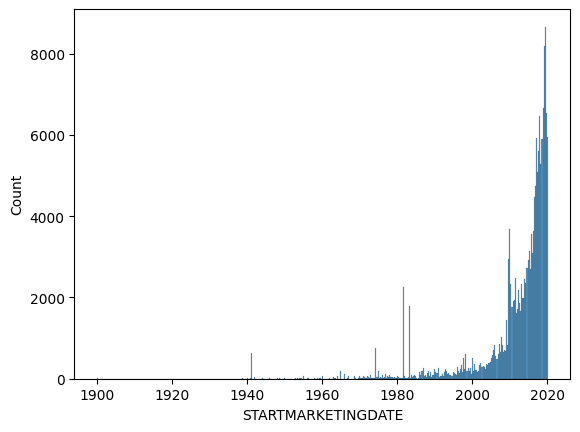

In [149]:
sns.histplot(pack, x="STARTMARKETINGDATE")

In [150]:
pack["STARTMARKETINGDATE"].value_counts()

1981-09-15    2200
2019-05-06    1841
2010-02-03    1790
1983-03-03    1769
2009-09-01    1347
              ... 
2002-06-19       1
2014-04-20       1
1992-06-18       1
2002-06-18       1
1997-02-27       1
Name: STARTMARKETINGDATE, Length: 7371, dtype: int64

Lot's of data. Later we could split into different time bins to reduce the skewness and encode them into numerical vals

Verification for ENDMARKETINGDATE

In [151]:
# Converto to datetime END
pack["ENDMARKETINGDATE"] = pd.to_datetime(pack["ENDMARKETINGDATE"], format="%Y%m%d")

In [152]:
print(f'There are {pack.isnull().sum()["ENDMARKETINGDATE"]} null in ENDMARKETINGDATE')

There are 166916 null in ENDMARKETINGDATE


In [153]:
# Over 75% of entries are null
na75_threshold = 0.75*len(pack)
print(pack.isnull().sum()[pack.isnull().sum() > na75_threshold].index.to_list())

['ENDMARKETINGDATE']


Let's convert to a binary since there is over 75% of null vals

In [154]:
pd.DataFrame(np.where(pack["ENDMARKETINGDATE"].notnull(), 1, 0)).value_counts()

0    166916
1      6297
dtype: int64

In [155]:
pack["ENDMARKETINGDATE_determined"] = np.where(pack["ENDMARKETINGDATE"].notnull(), 1, 0)
pack = pack.drop(columns="ENDMARKETINGDATE")

**NDC_EXCLUDE_FLAG verification**

In [156]:
# Counts
pack["NDC_EXCLUDE_FLAG"].value_counts()

N    173213
Name: NDC_EXCLUDE_FLAG, dtype: int64

Same as in the product table, a single value for every sample. Drop the column

In [157]:
pack = pack.drop(columns="NDC_EXCLUDE_FLAG")

**SAMPLE_PACKAGE verification + convert to binary**

In [158]:
# Possible values
pack["SAMPLE_PACKAGE"].value_counts()

N    172554
Y       659
Name: SAMPLE_PACKAGE, dtype: int64

Binary feature but not in the right type, let's convert to binary

In [159]:
pd.DataFrame(np.where(pack["SAMPLE_PACKAGE"] == "N", 0, 1)).head()

,0
0,0
1,0
2,0
3,1
4,0


In [160]:
pack["SAMPLE_PACKAGE"] = np.where(pack["SAMPLE_PACKAGE"] == "N", 0, 1)

In [161]:
pack.head()

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,1987-07-10,0,mL,0
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,1,mL,0
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,0,mL,0


In [162]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,...,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]",1,0,0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",...,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]",0,1,0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,...,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]",1,0,0


---

## 4. Replacing missing values in prod and pack tables

**We will need to convert some of the categorical data to numerical data using get_dummies or onehotencoding in both tables**

### product table : 

1. Note that the null values in the PHARM_CLASSES feature are the objects we want to predict the class of. Basically our classification task
2. Convert categorical data to proper format for imputation
3. Use different imputation techniques for each feature with missing values

PHARM_CLASSES missing values (to predict)

In [163]:
#
print(f"There are {prod['PHARM_CLASSES'].isnull().sum()} objects we want to predict the PHARM_CLASSES of")

There are 50917 objects we want to predict the PHARM_CLASSES of


In [164]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
0,NaN,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,...,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]",1,0,0
1,NaN,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",...,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]",0,1,0
2,NaN,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
3,NaN,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
4,NaN,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,...,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]",1,0,0


Brief summary of features with missing values:
- productID we cannot impute since it is the combination of the NDC and the hashed value of the SPL documentID. We can just replace it with the PRODUCTNDC + some string to identify it differently.
- ProprietaryName and NonProprietaryName are logically linked so we can build a model (KNN classif) with one another to impute the missing categories from one another if the NaN are not common
- ApplicationNumber for unapproved drugs is null. thus convert all NaN to "unapproved"
- For RouteName, we can use logically linked attributes such as ProductTypeName, ProprietaryName and NonProprietaryName to train a model (KNN classif) and impute the data of the missing fields
- For the 3 linked attributes SUBSTANCENAME_list, ACTIVE_NUMERATOR_STRENGTH_list, ACTIVE_INGRED_UNIT_list we can do the same as above

In [165]:
prod.isnull().sum()[prod.isnull().sum() > 0].drop("PHARM_CLASSES")

PRODUCTID                          1560
PROPRIETARYNAME                       6
NONPROPRIETARYNAME                    4
APPLICATIONNUMBER                 13097
ROUTENAME_list                     1886
SUBSTANCENAME_list                 2248
ACTIVE_NUMERATOR_STRENGTH_list     2248
ACTIVE_INGRED_UNIT_list            2248
dtype: int64

**Add unique ProductIDs**

In [166]:
# Replacing missing id
for i in prod[prod["PRODUCTID"].isnull()]["PRODUCTID"].index:
    prod.loc[i, "PRODUCTID"] = f"missingID_{i}"
    
print(prod["PRODUCTID"].isnull().sum())

0


In [167]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
0,missingID_0,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,...,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]",1,0,0
1,missingID_1,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",...,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]",0,1,0
2,missingID_2,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
3,missingID_3,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
4,missingID_4,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,...,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]",1,0,0


**Missing values in PROPRIETARYNAME and NONPROPRIETARYNAME**

In [168]:
prod.isnull().sum()[prod.isnull().sum() > 0][0:2]

PROPRIETARYNAME       6
NONPROPRIETARYNAME    4
dtype: int64

In [169]:
# Check if the missing vals in the feat1 are diff then feat2
print(prod[prod["PROPRIETARYNAME"].isnull()]["NONPROPRIETARYNAME"].isnull().sum())
print(prod[prod["NONPROPRIETARYNAME"].isnull()]["PROPRIETARYNAME"].isnull().sum())

0
0


OneHotEncoding and labelEncoding both features/labels alternatively 

In [170]:
# extracting non-NaNs data
pnp_df = prod[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
pnp_df = pnp_df.dropna()
pnp_df.head()

,PROPRIETARYNAME,NONPROPRIETARYNAME
0,STERILE DILUENT,DILUENT
1,AMYVID,FLORBETAPIR F 18
2,TRULICITY,DULAGLUTIDE
3,TRULICITY,DULAGLUTIDE
4,EMGALITY,GALCANEZUMAB


In [171]:
# Imputing ProprietaryName first, so ohe on Non-Pname and labelencoding on Pname
# X = pnp_df["NONPROPRIETARYNAME"]
# y = pnp_df["PROPRIETARYNAME"]
# ohe on nonpname feature
ohe = OneHotEncoder()
X = ohe.fit_transform(pnp_df[["NONPROPRIETARYNAME"]]).toarray()
le = LabelEncoder()
le.fit(pnp_df["PROPRIETARYNAME"])
y = le.transform(pnp_df["PROPRIETARYNAME"])

In [172]:
#Split in train_test with 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Optimize the K for KNN

In [173]:
# Optimize K
def optimize_k_knnclassif(min_k, max_k, X_train, X_test, y_train, y_test):
    highest_score = None
    best_k = None
    for k in range(min_k, max_k+1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)    # Train the model
        # Predictions
        y_pred = knn.predict(X_test)

        print(f"Training set mean accuracy for k={k}: {knn.score(X_train, y_train):.4f}")
        print(f"Test set mean accuracy for k={k}: {metrics.accuracy_score(y_test, y_pred):.4f}")
        test_score = metrics.accuracy_score(y_test, y_pred)
        if highest_score is None:
            highest_score = test_score
            best_k = k
        if highest_score < test_score:
            highest_score = test_score
            best_k = k
    print(f"Highest test score is {highest_score:.4f} with k={best_k}")

In [174]:
#optimize_k(3, 3, X_train, X_test, y_train, y_test)

Too many categories to train the model (+10 min later for a single k=3 iteration incomplete)

In [175]:
# DecTree 
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(f"Training set mean accuracy : {clf.score(X_train, y_train):.4f}")
# print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Again too long to train the model (+10 min later for a single iteration incomplete)

We will use a simpler imputation technique to just use the most frequent value based on the other feature respectively

In [176]:
pnp_df = prod[["PROPRIETARYNAME", "NONPROPRIETARYNAME"]]
pnp_df.head()

,PROPRIETARYNAME,NONPROPRIETARYNAME
0,STERILE DILUENT,DILUENT
1,AMYVID,FLORBETAPIR F 18
2,TRULICITY,DULAGLUTIDE
3,TRULICITY,DULAGLUTIDE
4,EMGALITY,GALCANEZUMAB


In [177]:
np_vals_pname_unknowns = pnp_df[pnp_df["PROPRIETARYNAME"].isnull()]["NONPROPRIETARYNAME"]
np_vals_pname_unknowns

80717              DULOXETINE DELAYED-RELEASE CAPSULES
80718              DULOXETINE DELAYED-RELEASE CAPSULES
80719              DULOXETINE DELAYED-RELEASE CAPSULES
85212    ATROPINE SULFATE INJECTION USP, 0.5 MG/0.7 ML
85213      ATROPINE SULFATE INJECTION USP, 1 MG/0.7 ML
85214                         ATROPINE INJECTION, 2 MG
Name: NONPROPRIETARYNAME, dtype: object

In [178]:
for val in np_vals_pname_unknowns.unique():
    print(pnp_df[pnp_df["NONPROPRIETARYNAME"] == val]["PROPRIETARYNAME"].values)

[nan nan nan]
[nan]
[nan]
[nan]


In [179]:
for val in pnp_df[pnp_df["NONPROPRIETARYNAME"].isnull()]["PROPRIETARYNAME"].unique():
    print(pnp_df[pnp_df["PROPRIETARYNAME"] == val]["NONPROPRIETARYNAME"])

38786    NaN
Name: NONPROPRIETARYNAME, dtype: object
38789    NaN
Name: NONPROPRIETARYNAME, dtype: object
38797    NaN
Name: NONPROPRIETARYNAME, dtype: object
38798    NaN
Name: NONPROPRIETARYNAME, dtype: object


Well all of the values are NaN so we can't do anything with approach meaning the missing values are unique categories only appearing once. Let's just drop the objects then

In [180]:
prod.head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
0,missingID_0,0002-0800,HUMAN OTC DRUG,STERILE DILUENT,DILUENT,1987-07-10,NDA,NDA018781,10,NaN,...,0,0,[SUBCUTANEOUS],[WATER],[1],[mL/mL],"[INJECTION, SOLUTION]",1,0,0
1,missingID_1,0002-1200,HUMAN PRESCRIPTION DRUG,AMYVID,FLORBETAPIR F 18,2012-06-01,NDA,NDA202008,10,"Radioactive Diagnostic Agent [EPC],Positron Em...",...,0,0,[INTRAVENOUS],[FLORBETAPIR F-18],[51],[mCi/mL],"[INJECTION, SOLUTION]",0,1,0
2,missingID_2,0002-1433,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[.75],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
3,missingID_3,0002-1434,HUMAN PRESCRIPTION DRUG,TRULICITY,DULAGLUTIDE,2014-09-18,BLA,BLA125469,10,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",...,0,0,[SUBCUTANEOUS],[DULAGLUTIDE],[1.5],[mg/.5mL],"[INJECTION, SOLUTION]",1,0,0
4,missingID_4,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,GALCANEZUMAB,2018-09-27,BLA,BLA761063,10,NaN,...,0,0,[SUBCUTANEOUS],[GALCANEZUMAB],[120],[mg/mL],"[INJECTION, SOLUTION]",1,0,0


In [181]:
# Dropping the problematic objects
prod = prod.drop(prod[prod["PROPRIETARYNAME"].isnull()].index)
prod = prod.drop(prod[prod["NONPROPRIETARYNAME"].isnull()].index)

**Convert Nulls in ApplicationNumber to *unapproved* category**

In [182]:
prod["APPLICATIONNUMBER"] = prod["APPLICATIONNUMBER"].fillna("unapproved")

In [183]:
len(prod[prod["APPLICATIONNUMBER"].isnull()])

0

**Imputing NaNs for ROUTENAME with PRODUCTTYPENAME since it makes for a logical approach and also fewer categories so we will be able to train a KNNClassif with this subset of data**

In [184]:
print(f'There are {prod["ROUTENAME_list"].isnull().sum()} missing values in RouteName_list')

There are 1886 missing values in RouteName_list


Converting ProductTypeName and RouteName_list to numerical with

In [185]:
len(prod["PRODUCTTYPENAME"].unique())

7

We need to reduce the amount of repetitions for multiple values to a minimum, let's compare with a sorted list then convert to set if we reduce the amount of categories

In [186]:
print(f'There are initially {len(prod["ROUTENAME_list"].fillna("MISSING").value_counts())} categories')
print(f'There will be {len(prod["ROUTENAME_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x)))).value_counts())} with sorted/set/list strategy')

There are initially 174 categories
There will be 173 with sorted/set/list strategy


In [187]:
# Filtering and transforming NaN to MISSING cat
prod["ROUTENAME_list"] = prod["ROUTENAME_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x))) if x != "MISSING" else x)

# Converting back to NaN
prod["ROUTENAME_list"] = prod["ROUTENAME_list"].replace("MISSING", np.nan)

In [188]:
df_pt_rn = prod[["PRODUCTTYPENAME", "ROUTENAME_list"]]
df_pt_rn.head()

,PRODUCTTYPENAME,ROUTENAME_list
0,HUMAN OTC DRUG,[SUBCUTANEOUS]
1,HUMAN PRESCRIPTION DRUG,[INTRAVENOUS]
2,HUMAN PRESCRIPTION DRUG,[SUBCUTANEOUS]
3,HUMAN PRESCRIPTION DRUG,[SUBCUTANEOUS]
4,HUMAN PRESCRIPTION DRUG,[SUBCUTANEOUS]


In [189]:
# Save unknowns and remove from df
rn_unknowns = df_pt_rn[df_pt_rn["ROUTENAME_list"].isnull()]
df_pt_rn = df_pt_rn.drop(rn_unknowns.index)

In [190]:
# df_pt_rn["ROUTENAME_list"].str.join(" ").str.split(" ")

In [191]:
# Encoding feature
ohe = OneHotEncoder()
ohe.fit(df_pt_rn[["PRODUCTTYPENAME"]])
X = ohe.transform(df_pt_rn[["PRODUCTTYPENAME"]]).toarray()

# Encoding label
le = LabelEncoder()
le.fit(df_pt_rn["ROUTENAME_list"].str.join(" "))
y = le.transform(df_pt_rn["ROUTENAME_list"].str.join(" "))

In [192]:
# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [193]:
optimize_k_knnclassif(3, 4, X_train, X_test, y_train, y_test)

Training set mean accuracy for k=3: 0.3774
Test set mean accuracy for k=3: 0.3749
Training set mean accuracy for k=4: 0.6149
Test set mean accuracy for k=4: 0.6152
Highest test score is 0.6152 with k=4


In [194]:
optimize_k_knnclassif(5, 7, X_train, X_test, y_train, y_test)

Training set mean accuracy for k=5: 0.6149
Test set mean accuracy for k=5: 0.6152
Training set mean accuracy for k=6: 0.6149
Test set mean accuracy for k=6: 0.6152
Training set mean accuracy for k=7: 0.6149
Test set mean accuracy for k=7: 0.6151
Highest test score is 0.6152 with k=5


k=5 is the best but it is computationnaly expensive compared to decision tree which yields same accuracy

In [195]:
# DecTree 
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Training set mean accuracy : {clf.score(X_train, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

print(f"Mean from 10 folds cv : {np.mean(cross_val_score(clf, X, y, cv=10))}")

Training set mean accuracy : 0.6163
Test set mean accuracy : 0.6165


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Mean from 10 folds cv : 0.61605523603119


Let's use the decision tree to impute our missing vals since it's super fast and as accurate

In [196]:
# Getting predictions
y_pred = clf.predict(ohe.transform(rn_unknowns[["PRODUCTTYPENAME"]]))

In [197]:
# transform to str objects
rn_imputed = le.inverse_transform(y_pred)

In [198]:
# replace unknown df
rn_unknowns["ROUTENAME_list"] = rn_imputed

In [199]:
# Convert back to list type
rn_unknowns["ROUTENAME_list"] = rn_unknowns["ROUTENAME_list"].str.split(" ")

In [200]:
# Replace in original df
prod.loc[rn_unknowns["ROUTENAME_list"].index, "ROUTENAME_list"] = rn_unknowns["ROUTENAME_list"]

In [201]:
# Sanity check
prod["ROUTENAME_list"].isnull().sum()

0

In [202]:
rn_unknowns["ROUTENAME_list"].value_counts()

[ORAL]             1728
[INTRAVENOUS]       139
[INTRAMUSCULAR]      19
Name: ROUTENAME_list, dtype: int64

**Imputing the 3 linked attributes for UBSTANCENAME_list, ACTIVE_NUMERATOR_STRENGTH_list, ACTIVE_INGRED_UNIT_list**

We need to reduce the amount of repetitions for multiple values to a minimum, let's compare with a sorted list then convert to set if we reduce the amount of categories

In [203]:
prod["ACTIVE_INGRED_UNIT_list"]

0          [mL/mL]
1         [mCi/mL]
2        [mg/.5mL]
3        [mg/.5mL]
4          [mg/mL]
           ...    
93233       [mg/1]
93234       [mg/1]
93235       [mg/1]
93236       [mg/g]
93237       [mg/g]
Name: ACTIVE_INGRED_UNIT_list, Length: 93084, dtype: object

In [204]:
print(f'There are initially {len(prod["SUBSTANCENAME_list"].fillna("MISSING").value_counts())} categories for SUBSTANCENAME_list')
print(f'There will be {len(prod["SUBSTANCENAME_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x)))).value_counts())} with sorted/set/list strategy for SUBSTANCENAME_list')

There are initially 8949 categories for SUBSTANCENAME_list
There will be 7904 with sorted/set/list strategy for SUBSTANCENAME_list


In [205]:
# Filtering and transforming NaN to MISSING cat
prod["SUBSTANCENAME_list"] = prod["SUBSTANCENAME_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x))) if x != "MISSING" else x)

# Converting back to NaN
prod["SUBSTANCENAME_list"] = prod["SUBSTANCENAME_list"].replace("MISSING", np.nan)

In [206]:
print(f'There are initially {len(prod["ACTIVE_NUMERATOR_STRENGTH_list"].fillna("MISSING").value_counts())} categories for ACTIVE_NUMERATOR_STRENGTH_list')
print(f'There will be {len(prod["ACTIVE_NUMERATOR_STRENGTH_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x)))).value_counts())} with sorted/set/list strategy for ACTIVE_NUMERATOR_STRENGTH_list')

There are initially 8737 categories for ACTIVE_NUMERATOR_STRENGTH_list
There will be 5920 with sorted/set/list strategy for ACTIVE_NUMERATOR_STRENGTH_list


In [207]:
# Filtering and transforming NaN to MISSING cat
prod["ACTIVE_NUMERATOR_STRENGTH_list"] = prod["ACTIVE_NUMERATOR_STRENGTH_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x))) if x != "MISSING" else x)

# Converting back to NaN
prod["ACTIVE_NUMERATOR_STRENGTH_list"] = prod["ACTIVE_NUMERATOR_STRENGTH_list"].replace("MISSING", np.nan)

First convert to uppercase for ACTIVE_INGRED_UNIT_list since I forgot to do it previously

In [208]:
print(f'There are initially {len(prod["ACTIVE_INGRED_UNIT_list"].fillna("MISSING").value_counts())} categories for ACTIVE_INGRED_UNIT_list')
print(f'There will be {len(prod["ACTIVE_INGRED_UNIT_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x)))).value_counts())} with sorted/set/list strategy for ACTIVE_INGRED_UNIT_list')

There are initially 2377 categories for ACTIVE_INGRED_UNIT_list
There will be 1026 with sorted/set/list strategy for ACTIVE_INGRED_UNIT_list


In [209]:
# Filtering and transforming NaN to MISSING cat
prod["ACTIVE_INGRED_UNIT_list"] = prod["ACTIVE_INGRED_UNIT_list"].fillna("MISSING").apply(lambda x: list(set(sorted(x))) if x != "MISSING" else x)

In [210]:
prod["ACTIVE_INGRED_UNIT_list"].isnull().sum()

0

In [211]:
# Convert to uppercase
def convert_list_ele_upper(row):
    if row != "MISSING":
        changed_cased = [ele.upper() for ele in row if ele]
        return changed_cased
    else:
        return row

prod["ACTIVE_INGRED_UNIT_list"] = prod["ACTIVE_INGRED_UNIT_list"].apply(convert_list_ele_upper)

In [212]:
# Converting back to NaN
prod["ACTIVE_INGRED_UNIT_list"] = prod["ACTIVE_INGRED_UNIT_list"].replace("MISSING", np.nan)

**Using a simple DecisionTreeClassifier to impute missing data in all 3 linked attributes**

Using RouteName and DOSAGEFORMNAME as features for our decisionTree imputer. First we need to convert these 2 features to numerical using a MultiLabelBinarizer

In [213]:
# Convert to str temporarily
temp_df = prod[["ROUTENAME_list", "DOSAGEFORMNAME_list", "SUBSTANCENAME_list", "ACTIVE_NUMERATOR_STRENGTH_list", "ACTIVE_INGRED_UNIT_list"]]
# route_dosage_name_df["ROUTENAME_list"] = route_dosage_name_df["ROUTENAME_list"].str.join(" ")
# route_dosage_name_df["DOSAGEFORMNAME_list"] = route_dosage_name_df["DOSAGEFORMNAME_list"].str.join(" ")

# # Encoding label
# le = LabelEncoder()
# le.fit(df[y_col].dropna().str.join(" "))
# y = le.transform(df[y].str.join(" "))


In [214]:
temp_df_unknowns = temp_df[temp_df.isnull().any(axis=1)]
temp_df_knowns = temp_df.dropna()

In [215]:
# MultiLabelBinarizer for RouteName
mlb = MultiLabelBinarizer()
mlb.fit(temp_df_knowns["ROUTENAME_list"])
rn_col_names = [f"MLB_ROUTENAME_{col}" for col in mlb.classes_]
rn_col_names
rn_df = pd.DataFrame(mlb.transform(temp_df_knowns["ROUTENAME_list"]), columns=rn_col_names,index=temp_df_knowns["ROUTENAME_list"].index)
rn_df_unknowns = pd.DataFrame(mlb.transform(temp_df_unknowns["ROUTENAME_list"]), columns=rn_col_names,index=temp_df_unknowns["ROUTENAME_list"].index)

/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['ELECTRO-OSMOSIS'] will be ignored
  warnings.warn(


In [216]:
# MultiLabelBinarizer for DosageFormName
mlb = MultiLabelBinarizer()
mlb.fit(temp_df_knowns["DOSAGEFORMNAME_list"])
dosage_col_names = [f"MLB_DOSAGE_{col}" for col in mlb.classes_]
dosage_col_names
dosage_df = pd.DataFrame(mlb.transform(temp_df_knowns["DOSAGEFORMNAME_list"]), columns=dosage_col_names,index=temp_df_knowns["DOSAGEFORMNAME_list"].index)
dosage_df_unknowns = pd.DataFrame(mlb.transform(temp_df_unknowns["DOSAGEFORMNAME_list"]), columns=dosage_col_names,index=temp_df_unknowns["DOSAGEFORMNAME_list"].index)

/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['KIT'] will be ignored
  warnings.warn(


In [217]:
rn_dosage_df = pd.merge(rn_df, dosage_df, left_index=True, right_index=True)
rn_dosage_df_unknowns = pd.merge(rn_df_unknowns, dosage_df_unknowns, left_index=True, right_index=True)

In [218]:
X = rn_dosage_df

In [219]:
# Encoding SUBSTANCENAME_list
le = LabelEncoder()
le.fit(temp_df_knowns["SUBSTANCENAME_list"].str.join(" "))
y = le.transform(temp_df_knowns["SUBSTANCENAME_list"].str.join(" "))

In [220]:
# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [221]:
# DecTree to predict SUBSTANCENAME_list 
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("DecisionTree for SUBSTANCENAME_list\n")
print(f"Training set mean accuracy : {clf.score(X_train, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

print(f"Mean from 10 folds cv : {np.mean(cross_val_score(clf, X, y, cv=10))}")

# retrain on full dataset
clf.fit(X, y)
print(f"Full set model accuracy : {clf.score(X, y):.4f}")

DecisionTree for SUBSTANCENAME_list

Training set mean accuracy : 0.1473
Test set mean accuracy : 0.1421


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Mean from 10 folds cv : 0.13758861292547764
Full set model accuracy : 0.1472


In [222]:
# Impute missing data for 
subname_imputed = le.inverse_transform(clf.predict(rn_dosage_df_unknowns))

In [223]:
# Replace on unknown df
temp_df_unknowns["SUBSTANCENAME_list"] = subname_imputed

/tmp/ipykernel_168064/2745823623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["SUBSTANCENAME_list"] = subname_imputed


In [224]:
# Convert back to list type
temp_df_unknowns["SUBSTANCENAME_list"] = temp_df_unknowns["SUBSTANCENAME_list"].str.split(" ")

/tmp/ipykernel_168064/11294253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["SUBSTANCENAME_list"] = temp_df_unknowns["SUBSTANCENAME_list"].str.split(" ")


In [225]:
# Replace in original df
prod.loc[temp_df_unknowns["SUBSTANCENAME_list"].index, "SUBSTANCENAME_list"] = temp_df_unknowns["SUBSTANCENAME_list"]

In [226]:
# Sanity check
prod["SUBSTANCENAME_list"].isnull().sum()

0

In [227]:
# Encoding ACTIVE_NUMERATOR_STRENGTH_list
le = LabelEncoder()
le.fit(temp_df_knowns["ACTIVE_NUMERATOR_STRENGTH_list"].str.join(" "))
y = le.transform(temp_df_knowns["ACTIVE_NUMERATOR_STRENGTH_list"].str.join(" "))

In [228]:
# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [229]:
# DecTree to predict ACTIVE_NUMERATOR_STRENGTH_list 
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("DecisionTree for ACTIVE_NUMERATOR_STRENGTH_list\n")
print(f"Training set mean accuracy : {clf.score(X_train, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

print(f"Mean from 10 folds cv : {np.mean(cross_val_score(clf, X, y, cv=10))}")

# retrain on full dataset
clf.fit(X, y)
print(f"Full set model accuracy : {clf.score(X, y):.4f}")

DecisionTree for ACTIVE_NUMERATOR_STRENGTH_list

Training set mean accuracy : 0.1645
Test set mean accuracy : 0.1571


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Mean from 10 folds cv : 0.14846554789765293
Full set model accuracy : 0.1639


In [230]:
# Impute missing data for 
activnum_imputed = le.inverse_transform(clf.predict(rn_dosage_df_unknowns))

In [231]:
# Replace on unknown df
temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"] = activnum_imputed

/tmp/ipykernel_168064/652203488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"] = activnum_imputed


In [232]:
# Convert back to list type
temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"] = temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"].str.split(" ")

/tmp/ipykernel_168064/4165550991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"] = temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"].str.split(" ")


In [233]:
# Replace in original df
prod.loc[temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"].index, "ACTIVE_NUMERATOR_STRENGTH_list"] = temp_df_unknowns["ACTIVE_NUMERATOR_STRENGTH_list"]

In [234]:
# Sanity check
prod["ACTIVE_NUMERATOR_STRENGTH_list"].isnull().sum()

0

In [235]:
# Encoding ACTIVE_INGRED_UNIT_list
le = LabelEncoder()
le.fit(temp_df_knowns["ACTIVE_INGRED_UNIT_list"].str.join(" "))
y = le.transform(temp_df_knowns["ACTIVE_INGRED_UNIT_list"].str.join(" "))

In [236]:
# Split in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [237]:
# DecTree to predict ACTIVE_INGRED_UNIT_list 
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("DecisionTree for ACTIVE_INGRED_UNIT_list\n")
print(f"Training set mean accuracy : {clf.score(X_train, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

print(f"Mean from 10 folds cv : {np.mean(cross_val_score(clf, X, y, cv=10))}")

# retrain on full dataset
clf.fit(X, y)
print(f"Full set model accuracy : {clf.score(X, y):.4f}")

DecisionTree for ACTIVE_INGRED_UNIT_list

Training set mean accuracy : 0.6846
Test set mean accuracy : 0.6782


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Mean from 10 folds cv : 0.6731908223166043
Full set model accuracy : 0.6837


In [238]:
# Impute missing data for 
activeing_imputed = le.inverse_transform(clf.predict(rn_dosage_df_unknowns))

In [239]:
# Replace on unknown df
temp_df_unknowns["ACTIVE_INGRED_UNIT_list"] = activeing_imputed

/tmp/ipykernel_168064/4016197542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["ACTIVE_INGRED_UNIT_list"] = activeing_imputed


In [240]:
# Convert back to list type
temp_df_unknowns["ACTIVE_INGRED_UNIT_list"] = temp_df_unknowns["ACTIVE_INGRED_UNIT_list"].str.split(" ")

/tmp/ipykernel_168064/1428331301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_unknowns["ACTIVE_INGRED_UNIT_list"] = temp_df_unknowns["ACTIVE_INGRED_UNIT_list"].str.split(" ")


In [241]:
# Replace in original df
prod.loc[temp_df_unknowns["ACTIVE_INGRED_UNIT_list"].index, "ACTIVE_INGRED_UNIT_list"] = temp_df_unknowns["ACTIVE_INGRED_UNIT_list"]

In [242]:
# Sanity check
prod["ACTIVE_INGRED_UNIT_list"].isnull().sum()

0

In [243]:
prod.isnull().sum()[prod.isnull().sum() > 0]

PHARM_CLASSES    50913
dtype: int64

---

### pack table replacing NaNs

We only have productNDC to deal with

In [244]:
pack.isnull().sum()[pack.isnull().sum() > 0]

PRODUCTNDC    1500
dtype: int64

In [245]:
pack.head()

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,1987-07-10,0,mL,0
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,1,mL,0
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,0,mL,0


**Since product NDC is used as the first part before the underscore for the PRODUCTID, we can complete missing values from the PRODUCTID feature col**

In [246]:
pack[pack["PRODUCTNDC"].isnull()].head()

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
26357,13107-001_ae272efb-da52-4ff3-9ea9-353cef42a174,NaN,2009-08-17,0,TABLET,0
26358,13107-001_ae272efb-da52-4ff3-9ea9-353cef42a174,NaN,2009-08-17,0,TABLET,0
26359,13107-001_ae272efb-da52-4ff3-9ea9-353cef42a174,NaN,2009-08-17,0,TABLET,0
26360,13107-001_ae272efb-da52-4ff3-9ea9-353cef42a174,NaN,2009-08-17,0,TABLET,0
26361,13107-001_ae272efb-da52-4ff3-9ea9-353cef42a174,NaN,2009-08-17,0,TABLET,0


In [247]:
pack[pack["PRODUCTNDC"].isnull()]["PRODUCTID"].str.extract("^([0-9]*-[0-9]*)_").head()

,0
26357,13107-001
26358,13107-001
26359,13107-001
26360,13107-001
26361,13107-001


In [248]:
def get_missing_ndc(row):
    pattern = r"^([0-9]*-[0-9]*)_" 
    # Apply the regex pattern to column A and extract the result
    match = re.match(pattern, row["PRODUCTID"])
    # If column B is NaN for this row, replace it with the result from column A
    if match:
        result = match.group(1)
        # print(result)
        if pd.isna(row["PRODUCTNDC"]):
            row["PRODUCTNDC"] = result
        return row

pack = pack.apply(get_missing_ndc, axis=1)


In [249]:
pack.isnull().sum()

PRODUCTID                      0
PRODUCTNDC                     0
STARTMARKETINGDATE             0
SAMPLE_PACKAGE                 0
PACKAGEDESCRIPTION_FILTERED    0
ENDMARKETINGDATE_determined    0
dtype: int64

### 5. Remove duplicates in each tables

#### Duplicates in prod table

In [250]:
# Not considering the unique ID col
print("Number of rows total with duplication for all rows except the UniqueID first column :")
print(prod.iloc[:, 1:].astype(str).duplicated(keep=False).sum())

Number of rows total with duplication for all rows except the UniqueID first column :
1112


In [251]:
# Example
prod[prod.iloc[:, 1:].astype(str).duplicated(keep=False)].head()

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,NONPROPRIETARYNAME,STARTMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,PHARM_CLASSES,...,DEASCHEDULE_determined,PROPRIETARYNAMESUFFIX_determined,ROUTENAME_list,SUBSTANCENAME_list,ACTIVE_NUMERATOR_STRENGTH_list,ACTIVE_INGRED_UNIT_list,DOSAGEFORMNAME_list,LISTING_RECORD_CERTIFIED_THROUGH_2020-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_2021-12-31 00:00:00,LISTING_RECORD_CERTIFIED_THROUGH_undetermined
204,0006-3061_26fbe70d-7ea0-4ba1-90ad-8e7831eae0e1,0006-3061,HUMAN PRESCRIPTION DRUG,EMEND,FOSAPREPITANT DIMEGLUMINE,2017-02-03,NDA,NDA022023,10,"Neurokinin 1 Antagonists [MoA],Substance P/Neu...",...,0,0,[INTRAVENOUS],[FOSAPREPITANT DIMEGLUMINE],[150],[MG/5ML],"[INJECTION, POWDER, LYOPHILIZED, FOR SOLUTION]",0,1,0
205,0006-3061_53594fbb-5366-49af-b556-1a10a6d8d4b2,0006-3061,HUMAN PRESCRIPTION DRUG,EMEND,FOSAPREPITANT DIMEGLUMINE,2017-02-03,NDA,NDA022023,10,"Neurokinin 1 Antagonists [MoA],Substance P/Neu...",...,0,0,[INTRAVENOUS],[FOSAPREPITANT DIMEGLUMINE],[150],[MG/5ML],"[INJECTION, POWDER, LYOPHILIZED, FOR SOLUTION]",0,1,0
322,0009-0039_67759a7c-ea06-4151-87e1-a301c44d67cd,0009-0039,HUMAN PRESCRIPTION DRUG,SOLU-MEDROL,METHYLPREDNISOLONE SODIUM SUCCINATE,1959-04-02,NDA,NDA011856,PHARMACIA AND UPJOHN COMPANY LLC,"Corticosteroid [EPC],Corticosteroid Hormone Re...",...,0,0,"[INTRAVENOUS, INTRAMUSCULAR]",[METHYLPREDNISOLONE SODIUM SUCCINATE],[40],[MG/ML],"[INJECTION, POWDER, FOR SOLUTION]",1,0,0
323,0009-0039_95289567-4341-4b6c-bc3c-aa13036bc9b4,0009-0039,HUMAN PRESCRIPTION DRUG,SOLU-MEDROL,METHYLPREDNISOLONE SODIUM SUCCINATE,1959-04-02,NDA,NDA011856,PHARMACIA AND UPJOHN COMPANY LLC,"Corticosteroid [EPC],Corticosteroid Hormone Re...",...,0,0,"[INTRAVENOUS, INTRAMUSCULAR]",[METHYLPREDNISOLONE SODIUM SUCCINATE],[40],[MG/ML],"[INJECTION, POWDER, FOR SOLUTION]",1,0,0
325,0009-0047_67759a7c-ea06-4151-87e1-a301c44d67cd,0009-0047,HUMAN PRESCRIPTION DRUG,SOLU-MEDROL,METHYLPREDNISOLONE SODIUM SUCCINATE,1959-04-02,NDA,NDA011856,PHARMACIA AND UPJOHN COMPANY LLC,"Corticosteroid [EPC],Corticosteroid Hormone Re...",...,0,0,"[INTRAVENOUS, INTRAMUSCULAR]",[METHYLPREDNISOLONE SODIUM SUCCINATE],[125],[MG/2ML],"[INJECTION, POWDER, FOR SOLUTION]",1,0,0


In [252]:
print(f"Removing {prod.iloc[:, 1:].astype(str).duplicated().sum()} rows")

Removing 659 rows


In [253]:
# Removing all duplicates except first row
prod = prod.drop(prod[prod.iloc[:, 1:].astype(str).duplicated()].index)

In [254]:
print("No duplication in the PRODUCTID col")
prod["PRODUCTID"].duplicated(keep=False).sum()

No duplication in the PRODUCTID col


0

#### Duplicates in package table

In [255]:
# Not considering the unique ID col
print("Number of rows total with duplication INCLUDING THE PRODUCTID :")
print(pack.duplicated(keep=False).sum())

Number of rows total with duplication INCLUDING THE PRODUCTID :
101541


In [256]:
pack[pack.duplicated(keep=False)].head()

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
2,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
9,0002-1445_05ca6b40-080f-4d27-930c-9bbdc0d06afa,0002-1445,2016-03-22,0,mL,0
10,0002-1445_05ca6b40-080f-4d27-930c-9bbdc0d06afa,0002-1445,2016-03-22,0,mL,0
11,0002-1445_05ca6b40-080f-4d27-930c-9bbdc0d06afa,0002-1445,2016-03-22,0,mL,0


In [257]:
print(f"Removing {pack.duplicated().sum()} rows")

Removing 71998 rows


In [258]:
pack = pack.drop(pack[pack.duplicated()].index)

In [261]:
pack

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,1987-07-10,0,mL,0
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,2012-06-01,0,mL,0
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,1,mL,0
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,0,mL,0
5,0002-1434_42a80046-fd68-4b80-819c-a443b7816edb,0002-1434,2014-11-07,1,mL,0
...,...,...,...,...,...,...
173877,99207-466_7578e84a-41ed-498d-8c2b-56a9931679db,99207-466,2010-09-27,0,TABLET,0
173879,99207-467_7578e84a-41ed-498d-8c2b-56a9931679db,99207-467,2010-09-27,0,TABLET,0
173881,99207-525_d47eda34-3952-463c-9597-4225a19dbf13,99207-525,2006-03-13,0,g,0
173885,99207-850_76ac026f-e6f1-4d1f-8144-9b5492e2d1bb,99207-850,2013-11-14,1,g,0


**There are still some duplication in the PRODUCTID rows, we need to remove them**

In [266]:
print(f'{pack["PRODUCTID"].duplicated().sum()} rows to remove')

8469 rows to remove


In [270]:
pack[pack["PRODUCTID"].duplicated(keep=False)].head(6)

,PRODUCTID,PRODUCTNDC,STARTMARKETINGDATE,SAMPLE_PACKAGE,PACKAGEDESCRIPTION_FILTERED,ENDMARKETINGDATE_determined
3,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,1,mL,0
4,0002-1433_42a80046-fd68-4b80-819c-a443b7816edb,0002-1433,2014-11-07,0,mL,0
5,0002-1434_42a80046-fd68-4b80-819c-a443b7816edb,0002-1434,2014-11-07,1,mL,0
6,0002-1434_42a80046-fd68-4b80-819c-a443b7816edb,0002-1434,2014-11-07,0,mL,0
7,0002-1436_dd7f66eb-66e1-4ad0-a593-417dbf2c74e2,0002-1436,2018-09-27,0,mL,0
8,0002-1436_dd7f66eb-66e1-4ad0-a593-417dbf2c74e2,0002-1436,2018-09-27,1,mL,0


In [273]:
pack = pack.drop(pack[pack["PRODUCTID"].duplicated()].index)

### 6. Join product and package tables

In [282]:
rx_df = pd.merge(prod, pack, how="inner", on="PRODUCTID")

In [283]:
rx_df.shape

(90378, 26)

In [288]:
print(f"Number of duplicated rows : {rx_df.astype(str).duplicated().sum()}")

Number of duplicated rows : 0


In [292]:
rx_df.isnull().sum()[rx_df.isnull().sum() > 0]

PHARM_CLASSES    50112
dtype: int64

We loose some of the PHARM_CLASSES rows, maybe we can left_join and take care of the missing data in other rows

In [293]:
rx_df = pd.merge(prod, pack, how="left", on="PRODUCTID")

In [298]:
rx_df.isnull().sum()[rx_df.isnull().sum() > 0]

PHARM_CLASSES                    50457
PRODUCTNDC_y                      2047
STARTMARKETINGDATE_y              2047
SAMPLE_PACKAGE                    2047
PACKAGEDESCRIPTION_FILTERED       2047
ENDMARKETINGDATE_determined_y     2047
dtype: int64

We can safely remove the columns with duplicated names/information labelled with `_y`